In [1]:
import sys
import logging
import json
import numpy as np
import pandas as pd
from datetime import datetime
import time

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS
import sext_tools as st
from gen3_shared import prepare, get_eval_f, compute_family_k2l_from_knob_k2l, get_raw_eval_f

logger = logging.getLogger(__name__)

### SETUP

In [2]:
MODE = 'DW_SH1N_SH3N_SH4N_SL1_SL2_SL3_SH1DW081828_SH3DW081828_SH4DW081828'
NAME_ROOT = f'moga_{MODE}_v1'

from apsopt.util.log import prepare_loggers
prepare_loggers()
fh = logging.FileHandler(f'logs/{NAME_ROOT}_{datetime.now():%Y%m%dT%H%M%S}.optlog', mode='w')
fh.setLevel(logging.NOTSET)
logging.getLogger().addHandler(fh)

dfknobs, ivals_ref, ivals, gvocs, iknobvals = prepare(MODE)
variables = gvocs.variables

reference_point = {'LT': 3.0, # hours
                   'EFF': 10.0 # % injected
                   }

display(pd.DataFrame(ivals_ref,index=[0]))
display(pd.DataFrame(variables))

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,SH3-DW18,SH3-DW28,SH4-DW08,SH4-DW18,SH4-DW28
0,3.966582,-1.171022,-3.16418,-2.654321,7.135584,-5.892172,3.966582,3.966582,3.966582,-1.171022,-1.171022,-1.171022,-3.16418,-3.16418,-3.16418


,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,SH3-DW18,SH3-DW28,SH4-DW08,SH4-DW18,SH4-DW28
0,-0.47599,-0.140523,-0.379702,-0.318519,-0.85627,-0.707061,-0.47599,-0.47599,-0.47599,-0.140523,-0.140523,-0.140523,-0.379702,-0.379702,-0.379702
1,0.47599,0.140523,0.379702,0.318519,0.85627,0.707061,0.47599,0.47599,0.47599,0.140523,0.140523,0.140523,0.379702,0.379702,0.379702


In [3]:
#TEST_MODE = True
TEST_MODE = False

In [4]:
inputs_dict = compute_family_k2l_from_knob_k2l(
    dfknobs, {k:variables[k][0]+(variables[k][1]-variables[k][0])*0.25 for k in variables.keys()}, ivals, True)
inputs_dict

SH1N   : +3.967 + -0.238 -> +3.729
SH3N   : -1.171 + -0.070 -> -1.241
SH4N   : -3.164 + -0.190 -> -3.354
SL1    : -2.654 + -0.159 -> -2.814
SL2    : +7.136 + -0.428 -> +6.707
SL3    : -5.892 + -0.354 -> -6.246
SH1-DW08: +3.967 + -0.238 -> +3.729
SH1-DW18: +3.967 + -0.238 -> +3.729
SH1-DW28: +3.967 + -0.238 -> +3.729
SH3-DW08: -1.171 + -0.070 -> -1.241
SH3-DW18: -1.171 + -0.070 -> -1.241
SH3-DW28: -1.171 + -0.070 -> -1.241
SH4-DW08: -3.164 + -0.190 -> -3.354
SH4-DW18: -3.164 + -0.190 -> -3.354
SH4-DW28: -3.164 + -0.190 -> -3.354


{'SH1N': 3.7285874748000003,
 'SH3N': -1.2412829829199998,
 'SH4N': -3.3540309505200003,
 'SL1': -2.8135804826000004,
 'SL2': 6.7074492326,
 'SL3': -6.24570244932,
 'SH1-DW08': 3.7285874748000003,
 'SH1-DW18': 3.7285874748000003,
 'SH1-DW28': 3.7285874748000003,
 'SH3-DW08': -1.2412829829199998,
 'SH3-DW18': -1.2412829829199998,
 'SH3-DW28': -1.2412829829199998,
 'SH4-DW08': -3.3540309505200003,
 'SH4-DW18': -3.3540309505200003,
 'SH4-DW28': -3.3540309505200003}

### Test eval function

In [ ]:
# Test
if False and not TEST_MODE:
    raw_eval_f = get_raw_eval_f()
    raw_eval_f(inputs_dict, meas_bxb_tunes=True, meas_lifetime=True, meas_inj_eff=True)

In [5]:
eval_f = get_eval_f(TEST_MODE, gvocs, dfknobs, ivals)
ev = FunctionEvaluator(script=eval_f)

POP_SIZE = 8
generator_name = 'aps_moga'
gc = get_generator_class(generator_name)
gen = gc(gvocs=gvocs, population_size=POP_SIZE)
gen.reference_point = reference_point

[DEBUG][22:05:21.059 __init__.p   47] Creating converter from 7 to 5
[DEBUG][22:05:21.062 __init__.p   47] Creating converter from 5 to 7
[DEBUG][22:05:21.063 __init__.p   47] Creating converter from 7 to 5
[DEBUG][22:05:21.064 __init__.p   47] Creating converter from 5 to 7
[INFO ][22:05:21.120    moga.py   24] Initializing generator aps_moga
[INFO ][22:05:21.121 generator.   64] Initialized generator aps_moga
[INFO ][22:05:21.122   cnsga.py  283] Created toolbox with 15 variables, 0 constraints, and 2 objectives.
[INFO ][22:05:21.123   cnsga.py  286]     Using selection algorithm: nsga2


In [6]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options, generator=gen, evaluator=ev, gvocs=gvocs)

[DEBUG][22:05:21.132 optimizer.   83] Initializing optimizer with tag='fcf44162a0' store_history=True dump_every_step=True history_directory=None execution_mode='sync'
[DEBUG][22:05:21.133 optimizer.  138] Generator set to: supports_batch_generation=False supports_multi_objective=True vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1': [-0.31851854520000006, 0.31851854520000006], 'SL2': [-0.8562701148, 0.8562701148], 'SL3': [-0.70706065464, 0.70706065464], 'SH1-DW08': [-0.4759898904, 0.4759898904], 'SH1-DW18': [-0.4759898904, 0.4759898904], 'SH1-DW28': [-0.4759898904, 0.4759898904], 'SH3-DW08': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW18': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW28': [-0.14052260183999998, 0.14052260183999998], 'SH4-DW08': [-0.37970161704, 0.37970161704], 'SH4-DW18': [-0.37970161704, 0.37970161704], 'SH4-DW28': [-0.37970161704, 0.379701617

### Sample at initial values

In [7]:
opt.generate_at(iknobvals)
opt.evaluate_data()

[INFO ][22:05:25.327 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:05:25.329 evaluators  193] Data kwargs: row={'SH1N': -0.08, 'SH3N': -0.04, 'SH4N': 0.0, 'SL1': 0.0, 'SL2': -0.15, 'SL3': -0.15, 'SH1-DW08': 0.02, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH3-DW08': 0.02, 'SH3-DW18': 0.0, 'SH3-DW28': 0.0, 'SH4-DW08': 0.02, 'SH4-DW18': 0.0, 'SH4-DW28': 0.0}
[INFO ][22:05:25.334 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.8865824200000003, 'SH3N': -1.211021682, 'SH4N': -3.164180142, 'SL1': -2.6543212100000004, 'SL2': 6.98558429, 'SL3': -6.042172122000001, 'SH1-DW08': 3.9865824200000004, 'SH1-DW18': 3.9665824200000004, 'SH1-DW28': 3.9665824200000004, 'SH3-DW08': -1.1510216819999999, 'SH3-DW18': -1.171021682, 'SH3-DW28': -1.171021682, 'SH4-DW08': -3.144180142, 'SH4-DW18': -3.164180142, 'SH4-DW28': -3.164180142}


SH1N   : +3.967 + -0.080 -> +3.887
SH3N   : -1.171 + -0.040 -> -1.211
SH4N   : -3.164 + +0.000 -> -3.164
SL1    : -2.654 + +0.000 -> -2.654
SL2    : +7.136 + -0.150 -> +6.986
SL3    : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.020 -> +3.987
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + +0.000 -> -1.171
SH4-DW08: -3.164 + +0.020 -> -3.144
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + +0.000 -> -3.164
Sextupole adj. took 0.0.
Max FCOR I [A] = 0.003; RMS(dx, dy) [m] = (7.995e-07, 1.053e-06)
Orbit correction converged


[INFO ][22:05:29.409 opt_funcs.  734] Lifetime measurement START
[INFO ][22:05:39.803 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 6.863 (raw tau [hr] = 7.481, epsy [pm] = 12.91) (took 10.4 [s])
Inj. Eff. = 39.71 (took 17.6 [s])
Eval. func. finished.


[DEBUG][22:05:57.406 evaluators  211] Result: output={'result': {'_nux': 0.21377431433359628, '_nuy': 0.2684920047145507, '_eps_x_bxbOn': 1.0104123662791133e-09, '_eps_y_bxbOn': 1.2976377959653774e-11, '_eps_x_bxbOff': 1.010052481304052e-09, '_eps_y_bxbOff': 1.29123147484099e-11, 'LT': 6.862814542073151, '_raw_LT': 7.481198983337124, 'EFF': 39.70739371782885}, 'exception': None, 'traceback': '', 'wall_time': 32.075017034076154, 'cpu_time': 15.932728349999998}
[DEBUG][22:05:57.409 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:05:57.421 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00000.json] in [0.00866]s


MOGA add_data (+1): len(self._offspring)=1/8


In [8]:
assert opt.data.iloc[0].valid, f'ERROR: {opt.data.iloc[0].traceback}'
opt.data

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,-0.08,-0.04,0.0,0.0,-0.15,-0.15,0.02,0.0,0.0,0.02,...,True,0.213774,0.268492,1.010412e-09,1.297638e-11,1.010052e-09,1.291231e-11,6.862815,7.481199,39.707394


### Sample close to initial point

In [9]:
mt = {k: 0.05 for k in variables.keys()}
opt.generate_random_around_point(n=POP_SIZE-1, point=iknobvals, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

[INFO ][22:06:19.828 optimizer.  573] Evaluating 7 inputs
[DEBUG][22:06:19.830 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.016848669431300742, 'SH1-DW28': -0.016972444758883723, 'SH1N': -0.07385848328892797, 'SH3-DW08': 0.024397910332253782, 'SH3-DW18': 0.006729691999253509, 'SH3-DW28': 0.0025925331342369577, 'SH3N': -0.03752417479703294, 'SH4-DW08': 0.01078134086215777, 'SH4-DW18': 0.003136080040528004, 'SH4-DW28': 0.01566511046970933, 'SH4N': -0.003932956641545304, 'SL1': 0.004624996800759288, 'SL2': -0.12072826657544473, 'SL3': -0.1284249080260315}
[INFO ][22:06:19.834 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.8927239367110724, 'SH3N': -1.2085458567970329, 'SH4N': -3.1681130986415456, 'SL1': -2.649696213199241, 'SL2': 7.014856023424556, 'SL3': -6.020597030026032, 'SH1-DW08': 3.9673246805777627, 'SH1-DW18': 3.9497337505687, 'SH1-DW28': 3.9496099752411165, 'SH3-DW08': -1.146623771667746, 'SH3-DW18': -1.1642919900007465, 'SH3-DW28': -1.1

SH1N   : +3.967 + -0.074 -> +3.893
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.650
SL2    : +7.136 + -0.121 -> +7.015
SL3    : -5.892 + -0.128 -> -6.021
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + +0.003 -> -1.168
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + +0.016 -> -3.149
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.003; RMS(dx, dy) [m] = (8.706e-07, 1.066e-06)
Orbit correction converged


[INFO ][22:06:23.915 opt_funcs.  734] Lifetime measurement START
[INFO ][22:06:36.950 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 6.896 (raw tau [hr] = 7.583, epsy [pm] = 13.10) (took 13.0 [s])
Inj. Eff. = 45.57 (took 18.5 [s])
Eval. func. finished.


[DEBUG][22:06:55.481 evaluators  211] Result: output={'result': {'_nux': 0.21389638939031963, '_nuy': 0.268247864678292, '_eps_x_bxbOn': 1.0128546956257233e-09, '_eps_y_bxbOn': 1.3195831914044273e-11, '_eps_x_bxbOff': 1.0097148444032992e-09, '_eps_y_bxbOff': 1.3100937040987845e-11, 'LT': 6.895690655632043, '_raw_LT': 7.582987673254727, 'EFF': 45.57221688419999}, 'exception': None, 'traceback': '', 'wall_time': 35.65004835650325, 'cpu_time': 18.883617693}
[DEBUG][22:06:55.482 evaluators  193] Data kwargs: row={'SH1-DW08': 0.030755325364990947, 'SH1-DW18': 0.0196070725397731, 'SH1-DW28': 0.01696975861052637, 'SH1N': -0.10238714468187614, 'SH3-DW08': 0.01636654603156664, 'SH3-DW18': -0.00644489607856561, 'SH3-DW28': -0.004569591804060828, 'SH3N': -0.040290339236731074, 'SH4-DW08': 0.021895060561541425, 'SH4-DW18': -0.015703954562464532, 'SH4-DW28': -5.131341076832635e-05, 'SH4N': 0.016436956183098622, 'SL1': -0.0027527757223322624, 'SL2': -0.18760125519534712, 'SL3': -0.16127060474271035}

SH1N   : +3.967 + -0.102 -> +3.864
SH3N   : -1.171 + -0.040 -> -1.211
SH4N   : -3.164 + +0.016 -> -3.148
SL1    : -2.654 + -0.003 -> -2.657
SL2    : +7.136 + -0.188 -> +6.948
SL3    : -5.892 + -0.161 -> -6.053
SH1-DW08: +3.967 + +0.031 -> +3.997
SH1-DW18: +3.967 + +0.020 -> +3.986
SH1-DW28: +3.967 + +0.017 -> +3.984
SH3-DW08: -1.171 + +0.016 -> -1.155
SH3-DW18: -1.171 + -0.006 -> -1.177
SH3-DW28: -1.171 + -0.005 -> -1.176
SH4-DW08: -3.164 + +0.022 -> -3.142
SH4-DW18: -3.164 + -0.016 -> -3.180
SH4-DW28: -3.164 + -0.000 -> -3.164
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.087; RMS(dx, dy) [m] = (1.113e-06, 1.081e-06)
Orbit correction converged


[INFO ][22:06:59.564 opt_funcs.  734] Lifetime measurement START
[INFO ][22:07:08.484 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 6.792 (raw tau [hr] = 7.384, epsy [pm] = 12.78) (took 8.9 [s])
Inj. Eff. = 20.66 (took 16.5 [s])
Eval. func. finished.


[DEBUG][22:07:25.030 evaluators  211] Result: output={'result': {'_nux': 0.2133165580638538, '_nuy': 0.26847164879457536, '_eps_x_bxbOn': 1.0072885507942112e-09, '_eps_y_bxbOn': 1.2891751173203367e-11, '_eps_x_bxbOff': 1.0093584327866794e-09, '_eps_y_bxbOff': 1.2780697571566998e-11, 'LT': 6.79239591089879, '_raw_LT': 7.384068841082379, 'EFF': 20.65601488353097}, 'exception': None, 'traceback': '', 'wall_time': 29.546945529058576, 'cpu_time': 15.327856423}
[DEBUG][22:07:25.031 evaluators  193] Data kwargs: row={'SH1-DW08': 0.04134446476133512, 'SH1-DW18': -0.004630052170046788, 'SH1-DW28': -0.0017163459779709588, 'SH1N': -0.05882930009481471, 'SH3-DW08': 0.016907558920317353, 'SH3-DW18': -0.0027763090703923094, 'SH3-DW28': 0.0038660193737810895, 'SH3N': -0.043930852986123245, 'SH4-DW08': 0.031973417854169406, 'SH4-DW18': -0.004429235216263396, 'SH4-DW28': -0.018551352120145612, 'SH4N': 0.0008332495651490399, 'SL1': 0.0134807895138319, 'SL2': -0.13558944184211985, 'SL3': -0.1740490249004

SH1N   : +3.967 + -0.059 -> +3.908
SH3N   : -1.171 + -0.044 -> -1.215
SH4N   : -3.164 + +0.001 -> -3.163
SL1    : -2.654 + +0.013 -> -2.641
SL2    : +7.136 + -0.136 -> +7.000
SL3    : -5.892 + -0.174 -> -6.066
SH1-DW08: +3.967 + +0.041 -> +4.008
SH1-DW18: +3.967 + -0.005 -> +3.962
SH1-DW28: +3.967 + -0.002 -> +3.965
SH3-DW08: -1.171 + +0.017 -> -1.154
SH3-DW18: -1.171 + -0.003 -> -1.174
SH3-DW28: -1.171 + +0.004 -> -1.167
SH4-DW08: -3.164 + +0.032 -> -3.132
SH4-DW18: -3.164 + -0.004 -> -3.169
SH4-DW28: -3.164 + -0.019 -> -3.183
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.154; RMS(dx, dy) [m] = (1.462e-06, 1.212e-06)
Max FCOR I [A] = 0.122; RMS(dx, dy) [m] = (6.981e-06, 1.259e-06)
Max FCOR I [A] = 0.122; RMS(dx, dy) [m] = (6.981e-06, 1.259e-06)
Max FCOR I [A] = 0.116; RMS(dx, dy) [m] = (2.599e-06, 1.308e-06)
Max FCOR I [A] = 0.116; RMS(dx, dy) [m] = (2.599e-06, 1.308e-06)
Max FCOR I [A] = 0.117; RMS(dx, dy) [m] = (2.454e-06, 1.990e-06)
Max FCOR I [A] = 0.117; RMS(dx, dy) [m] = (2.454e-0

[INFO ][22:07:36.167 opt_funcs.  734] Lifetime measurement START
[INFO ][22:07:44.705 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 6.958 (raw tau [hr] = 7.631, epsy [pm] = 12.99) (took 8.5 [s])
Inj. Eff. = 38.52 (took 20.1 [s])
Eval. func. finished.


[DEBUG][22:08:04.768 evaluators  211] Result: output={'result': {'_nux': 0.21526967835392316, '_nuy': 0.2681563033471554, '_eps_x_bxbOn': 9.993530170379523e-10, '_eps_y_bxbOn': 1.3139839516890386e-11, '_eps_x_bxbOff': 1.0014956573445612e-09, '_eps_y_bxbOff': 1.2991556870617972e-11, 'LT': 6.957756796198965, '_raw_LT': 7.630857273507597, 'EFF': 38.520886074903196}, 'exception': None, 'traceback': '', 'wall_time': 39.7365489769727, 'cpu_time': 15.272636837}
[DEBUG][22:08:04.770 evaluators  193] Data kwargs: row={'SH1-DW08': 0.011725055631882142, 'SH1-DW18': 0.008001454868382236, 'SH1-DW28': 0.0017140498782266846, 'SH1N': -0.08757399414158652, 'SH3-DW08': 0.022331509880665408, 'SH3-DW18': 0.0033697894655413136, 'SH3-DW28': -0.0032068019196521925, 'SH3N': -0.0338630801362369, 'SH4-DW08': 0.00541332805847153, 'SH4-DW18': 0.014401493403878973, 'SH4-DW28': 0.003090526868411117, 'SH4N': -0.01687842065328779, 'SL1': -0.011872018249873481, 'SL2': -0.15434363254317313, 'SL3': -0.13625770439685048}

SH1N   : +3.967 + -0.088 -> +3.879
SH3N   : -1.171 + -0.034 -> -1.205
SH4N   : -3.164 + -0.017 -> -3.181
SL1    : -2.654 + -0.012 -> -2.666
SL2    : +7.136 + -0.154 -> +6.981
SL3    : -5.892 + -0.136 -> -6.028
SH1-DW08: +3.967 + +0.012 -> +3.978
SH1-DW18: +3.967 + +0.008 -> +3.975
SH1-DW28: +3.967 + +0.002 -> +3.968
SH3-DW08: -1.171 + +0.022 -> -1.149
SH3-DW18: -1.171 + +0.003 -> -1.168
SH3-DW28: -1.171 + -0.003 -> -1.174
SH4-DW08: -3.164 + +0.005 -> -3.159
SH4-DW18: -3.164 + +0.014 -> -3.150
SH4-DW28: -3.164 + +0.003 -> -3.161
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.033; RMS(dx, dy) [m] = (2.126e-06, 1.137e-06)
Orbit correction converged


[INFO ][22:08:08.851 opt_funcs.  734] Lifetime measurement START
[INFO ][22:08:16.747 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 6.953 (raw tau [hr] = 7.607, epsy [pm] = 12.91) (took 7.9 [s])
Inj. Eff. = 20.92 (took 17.6 [s])
Eval. func. finished.


[DEBUG][22:08:34.316 evaluators  211] Result: output={'result': {'_nux': 0.2149644907121147, '_nuy': 0.2681257795443805, '_eps_x_bxbOn': 9.965241355600802e-10, '_eps_y_bxbOn': 1.3021535546768469e-11, '_eps_x_bxbOff': 1.0022884062537143e-09, '_eps_y_bxbOff': 1.291119521107651e-11, 'LT': 6.95279347169834, '_raw_LT': 7.6067907584895655, 'EFF': 20.92391183087394}, 'exception': None, 'traceback': '', 'wall_time': 29.54492787644267, 'cpu_time': 14.409985426999995}
[DEBUG][22:08:34.317 evaluators  193] Data kwargs: row={'SH1-DW08': 0.01581678618646638, 'SH1-DW18': -0.007764138423813901, 'SH1-DW28': 0.02216467900206984, 'SH1N': -0.08403485459286462, 'SH3-DW08': 0.020495421210077212, 'SH3-DW18': 0.0040963316940698605, 'SH3-DW28': 0.00648421311761959, 'SH3N': -0.04682813838099144, 'SH4-DW08': 0.03743431433781223, 'SH4-DW18': -0.012425280077561496, 'SH4-DW28': -0.009824856975310582, 'SH4N': -0.009917382941771705, 'SL1': 0.010421337091253403, 'SL2': -0.1812949156514927, 'SL3': -0.14306178223543708

SH1N   : +3.967 + -0.084 -> +3.883
SH3N   : -1.171 + -0.047 -> -1.218
SH4N   : -3.164 + -0.010 -> -3.174
SL1    : -2.654 + +0.010 -> -2.644
SL2    : +7.136 + -0.181 -> +6.954
SL3    : -5.892 + -0.143 -> -6.035
SH1-DW08: +3.967 + +0.016 -> +3.982
SH1-DW18: +3.967 + -0.008 -> +3.959
SH1-DW28: +3.967 + +0.022 -> +3.989
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + +0.004 -> -1.167
SH3-DW28: -1.171 + +0.006 -> -1.165
SH4-DW08: -3.164 + +0.037 -> -3.127
SH4-DW18: -3.164 + -0.012 -> -3.177
SH4-DW28: -3.164 + -0.010 -> -3.174
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.023; RMS(dx, dy) [m] = (1.081e-06, 1.108e-06)
Orbit correction converged


[INFO ][22:08:38.427 opt_funcs.  734] Lifetime measurement START
[INFO ][22:08:44.339 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 7 (out of 180)
Lifetime = 6.940 (raw tau [hr] = 7.608, epsy [pm] = 12.94) (took 5.9 [s])
Inj. Eff. = 12.00 (took 17.5 [s])
Eval. func. finished.


[DEBUG][22:09:01.824 evaluators  211] Result: output={'result': {'_nux': 0.21486277493442932, '_nuy': 0.2680037246420333, '_eps_x_bxbOn': 9.987174765241231e-10, '_eps_y_bxbOn': 1.3018961603233677e-11, '_eps_x_bxbOff': 9.980167116447747e-10, '_eps_y_bxbOff': 1.2941148514347546e-11, 'LT': 6.9395269157546995, '_raw_LT': 7.607550302260237, 'EFF': 12.00318825669679}, 'exception': None, 'traceback': '', 'wall_time': 27.506009141914546, 'cpu_time': 12.298908884999989}
[DEBUG][22:09:01.825 evaluators  193] Data kwargs: row={'SH1-DW08': 0.033426048595153135, 'SH1-DW18': 0.004868827609470463, 'SH1-DW28': -0.02216819479915416, 'SH1N': -0.06571515262847256, 'SH3-DW08': 0.018509057562810155, 'SH3-DW18': -0.0038046845033049984, 'SH3-DW28': -0.0005568724969939286, 'SH3N': -0.03537793132343372, 'SH4-DW08': 0.009407244492302456, 'SH4-DW18': 0.006972157560948572, 'SH4-DW28': 0.006521930816087863, 'SH4N': 0.008088431867961255, 'SL1': -0.012061944730624717, 'SL2': -0.10903496645688728, 'SL3': -0.185298126

SH1N   : +3.967 + -0.066 -> +3.901
SH3N   : -1.171 + -0.035 -> -1.206
SH4N   : -3.164 + +0.008 -> -3.156
SL1    : -2.654 + -0.012 -> -2.666
SL2    : +7.136 + -0.109 -> +7.027
SL3    : -5.892 + -0.185 -> -6.077
SH1-DW08: +3.967 + +0.033 -> +4.000
SH1-DW18: +3.967 + +0.005 -> +3.971
SH1-DW28: +3.967 + -0.022 -> +3.944
SH3-DW08: -1.171 + +0.019 -> -1.153
SH3-DW18: -1.171 + -0.004 -> -1.175
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.009 -> -3.155
SH4-DW18: -3.164 + +0.007 -> -3.157
SH4-DW28: -3.164 + +0.007 -> -3.158
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.011; RMS(dx, dy) [m] = (9.041e-07, 1.131e-06)
Orbit correction converged


[INFO ][22:09:05.903 opt_funcs.  734] Lifetime measurement START
[INFO ][22:09:11.749 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 6.986 (raw tau [hr] = 7.720, epsy [pm] = 13.14) (took 5.8 [s])
Inj. Eff. = 45.40 (took 18.6 [s])
Eval. func. finished.


[DEBUG][22:09:30.356 evaluators  211] Result: output={'result': {'_nux': 0.21536122960787163, '_nuy': 0.26794267703648356, '_eps_x_bxbOn': 9.994947688995462e-10, '_eps_y_bxbOn': 1.3106062240550617e-11, '_eps_x_bxbOff': 9.965055540676004e-10, '_eps_y_bxbOff': 1.3138505710763404e-11, 'LT': 6.986219271056407, '_raw_LT': 7.719815863450482, 'EFF': 45.395968533142536}, 'exception': None, 'traceback': '', 'wall_time': 28.52969699446112, 'cpu_time': 12.243566618999992}
[DEBUG][22:09:30.357 evaluators  193] Data kwargs: row={'SH1-DW08': 0.020586096131442203, 'SH1-DW18': -0.020030690955535592, 'SH1-DW28': 0.006930579277915853, 'SH1N': -0.09290503550371207, 'SH3-DW08': 0.014658679130706514, 'SH3-DW18': -0.00014639037169568696, 'SH3-DW28': 0.0017265832814370424, 'SH3N': -0.0387438212106427, 'SH4-DW08': 0.015982671163880812, 'SH4-DW18': 0.013532997871315872, 'SH4-DW28': 0.012859435509603875, 'SH4N': 0.013909332130767262, 'SL1': 0.0033240006012345558, 'SL2': -0.16104683593286823, 'SL3': -0.150019328

SH1N   : +3.967 + -0.093 -> +3.874
SH3N   : -1.171 + -0.039 -> -1.210
SH4N   : -3.164 + +0.014 -> -3.150
SL1    : -2.654 + +0.003 -> -2.651
SL2    : +7.136 + -0.161 -> +6.975
SL3    : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.021 -> +3.987
SH1-DW18: +3.967 + -0.020 -> +3.947
SH1-DW28: +3.967 + +0.007 -> +3.974
SH3-DW08: -1.171 + +0.015 -> -1.156
SH3-DW18: -1.171 + -0.000 -> -1.171
SH3-DW28: -1.171 + +0.002 -> -1.169
SH4-DW08: -3.164 + +0.016 -> -3.148
SH4-DW18: -3.164 + +0.014 -> -3.151
SH4-DW28: -3.164 + +0.013 -> -3.151
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.011; RMS(dx, dy) [m] = (1.107e-06, 1.122e-06)
Orbit correction converged


[INFO ][22:09:34.435 opt_funcs.  734] Lifetime measurement START
[INFO ][22:09:43.328 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 6.945 (raw tau [hr] = 7.640, epsy [pm] = 13.00) (took 8.9 [s])
Inj. Eff. = 29.80 (took 18.6 [s])
Eval. func. finished.


[DEBUG][22:10:01.939 evaluators  211] Result: output={'result': {'_nux': 0.2152900141195223, '_nuy': 0.2681257795443805, '_eps_x_bxbOn': 1.001097995365467e-09, '_eps_y_bxbOn': 1.3067421215603348e-11, '_eps_x_bxbOff': 9.997410605153123e-10, '_eps_y_bxbOff': 1.3001245026094085e-11, 'LT': 6.944893584551022, '_raw_LT': 7.639930721410171, 'EFF': 29.79521618277019}, 'exception': None, 'traceback': '', 'wall_time': 31.58122532069683, 'cpu_time': 15.315634988}
[DEBUG][22:10:01.943 optimizer.  291] Adding (7) new data to internal dataframes
[DEBUG][22:10:01.975 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00001.json] in [0.02200]s


MOGA add_data (+7): len(self._offspring)=8/8
MOGA add_data: creating next generation


In [10]:
opt.data

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,-0.080000,-0.040000,0.000000,0.000000,-0.150000,-0.150000,0.020000,0.000000,0.000000,0.020000,...,True,0.213774,0.268492,1.010412e-09,1.297638e-11,1.010052e-09,1.291231e-11,6.862815,7.481199,39.707394
2,-0.073858,-0.037524,-0.003933,0.004625,-0.120728,-0.128425,0.000742,-0.016849,-0.016972,0.024398,...,True,0.213896,0.268248,1.012855e-09,1.319583e-11,1.009715e-09,1.310094e-11,6.895691,7.582988,45.572217
3,-0.102387,-0.040290,0.016437,-0.002753,-0.187601,-0.161271,0.030755,0.019607,0.016970,0.016367,...,True,0.213317,0.268472,1.007289e-09,1.289175e-11,1.009358e-09,1.278070e-11,6.792396,7.384069,20.656015
4,-0.058829,-0.043931,0.000833,0.013481,-0.135589,-0.174049,0.041344,-0.004630,-0.001716,0.016908,...,True,0.215270,0.268156,9.993530e-10,1.313984e-11,1.001496e-09,1.299156e-11,6.957757,7.630857,38.520886
5,-0.087574,-0.033863,-0.016878,-0.011872,-0.154344,-0.136258,0.011725,0.008001,0.001714,0.022332,...,True,0.214964,0.268126,9.965241e-10,1.302154e-11,1.002288e-09,1.291120e-11,6.952793,7.606791,20.923912
6,-0.084035,-0.046828,-0.009917,0.010421,-0.181295,-0.143062,0.015817,-0.007764,0.022165,0.020495,...,True,0.214863,0.268004,9.987175e-10,1.301896e-11,9.980167e-10,1.294115e-11,6.939527,7.607550,12.003188
7,-0.065715,-0.035378,0.008088,-0.012062,-0.109035,-0.185298,0.033426,0.004869,-0.022168,0.018509,...,True,0.215361,0.267943,9.994948e-10,1.310606e-11,9.965056e-10,1.313851e-11,6.986219,7.719816,45.395969
8,-0.092905,-0.038744,0.013909,0.003324,-0.161047,-0.150019,0.020586,-0.020031,0.006931,0.014659,...,True,0.215290,0.268126,1.001098e-09,1.306742e-11,9.997411e-10,1.300125e-11,6.944894,7.639931,29.795216


### Run optimizer

In [11]:
opt.step()

[DEBUG][22:10:37.939 optimizer.  447] Generating 1 candidates
[DEBUG][22:10:37.947 optimizer.  488] Generated 1 inputs
[INFO ][22:10:37.952 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:10:37.954 evaluators  193] Data kwargs: row={'SH1-DW08': 0.029953550194081136, 'SH1-DW18': 0.016100839335205848, 'SH1-DW28': 0.02214582228686737, 'SH1N': -0.10280799367261428, 'SH3-DW08': 0.016553636957072727, 'SH3-DW18': 0.0035080052053349914, 'SH3-DW28': 0.0066485811926494665, 'SH3N': -0.046640667086253695, 'SH4-DW08': 0.036972689176789426, 'SH4-DW18': -0.012425280077561496, 'SH4-DW28': -0.0001047374474673693, 'SH4N': -0.009917382941771705, 'SL1': -0.002662464210640784, 'SL2': -0.1812949156514927, 'SL3': -0.1423208098950827}
[INFO ][22:10:37.958 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.863774426327386, 'SH3N': -1.2176623490862535, 'SH4N': -3.174097524941772, 'SL1': -2.6569836742106414, 'SL2': 6.954289374348508, 'SL3': -6.034492931895083, 'SH1-DW08': 3.9965359701940817, 'SH1-DW18': 3.9826832

SH1N   : +3.967 + -0.103 -> +3.864
SH3N   : -1.171 + -0.047 -> -1.218
SH4N   : -3.164 + -0.010 -> -3.174
SL1    : -2.654 + -0.003 -> -2.657
SL2    : +7.136 + -0.181 -> +6.954
SL3    : -5.892 + -0.142 -> -6.034
SH1-DW08: +3.967 + +0.030 -> +3.997
SH1-DW18: +3.967 + +0.016 -> +3.983
SH1-DW28: +3.967 + +0.022 -> +3.989
SH3-DW08: -1.171 + +0.017 -> -1.154
SH3-DW18: -1.171 + +0.004 -> -1.168
SH3-DW28: -1.171 + +0.007 -> -1.164
SH4-DW08: -3.164 + +0.037 -> -3.127
SH4-DW18: -3.164 + -0.012 -> -3.177
SH4-DW28: -3.164 + -0.000 -> -3.164
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.045; RMS(dx, dy) [m] = (1.240e-06, 1.147e-06)
Orbit correction converged


[INFO ][22:10:42.036 opt_funcs.  734] Lifetime measurement START
[INFO ][22:10:49.020 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 6.907 (raw tau [hr] = 7.577, epsy [pm] = 12.88) (took 7.0 [s])
Inj. Eff. = 8.95 (took 18.1 [s])
Eval. func. finished.


[DEBUG][22:11:07.156 evaluators  211] Result: output={'result': {'_nux': 0.21438466946283696, '_nuy': 0.2683394058550524, '_eps_x_bxbOn': 1.0019841547117628e-09, '_eps_y_bxbOn': 1.296823356645951e-11, '_eps_x_bxbOff': 9.991236096024706e-10, '_eps_y_bxbOff': 1.2881309545501797e-11, 'LT': 6.907143852423785, '_raw_LT': 7.577430427088199, 'EFF': 8.951966613899716}, 'exception': None, 'traceback': '', 'wall_time': 29.200515282340348, 'cpu_time': 13.63035056599999}
[DEBUG][22:11:07.159 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:11:07.184 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00002.json] in [0.02079]s


MOGA add_data (+1): len(self._offspring)=1/8


In [12]:
for i in range(8*5+1):
    print(f'\n** Step #{i+1} at {datetime.now():%Y-%m-%d %H:%M:%S}**\n')
    opt.step()

[DEBUG][22:11:51.108 optimizer.  447] Generating 1 candidates
[DEBUG][22:11:51.112 optimizer.  488] Generated 1 inputs
[INFO ][22:11:51.119 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:11:51.121 evaluators  193] Data kwargs: row={'SH1-DW08': 0.016618561357376188, 'SH1-DW18': 0.0196070725397731, 'SH1-DW28': 0.016988615325728842, 'SH1N': -0.0961239660762696, 'SH3-DW08': 0.008662511691852889, 'SH3-DW18': -0.0058565695898307405, 'SH3-DW28': -0.004733959879090704, 'SH3N': -0.040477810531468816, 'SH4-DW08': 0.02235668572256423, 'SH4-DW18': -0.015703954562464532, 'SH4-DW28': -0.00977143293861154, 'SH4N': 0.016436956183098622, 'SL1': 0.010331025579561925, 'SL2': -0.18760125519534712, 'SL3': -0.16201157708306477}
[INFO ][22:11:51.125 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.870458453923731, 'SH3N': -1.2114994925314688, 'SH4N': -3.1477431858169016, 'SL1': -2.6439901844204385, 'SL2': 6.947983034804653, 'SL3': -6.054183699083065, 'SH1-DW08': 3.9832009813573768, 'SH1-DW18': 3.9861894925


** Step #1 at 2023-12-16 22:11:51**

SH1N   : +3.967 + -0.096 -> +3.870
SH3N   : -1.171 + -0.040 -> -1.211
SH4N   : -3.164 + +0.016 -> -3.148
SL1    : -2.654 + +0.010 -> -2.644
SL2    : +7.136 + -0.188 -> +6.948
SL3    : -5.892 + -0.162 -> -6.054
SH1-DW08: +3.967 + +0.017 -> +3.983
SH1-DW18: +3.967 + +0.020 -> +3.986
SH1-DW28: +3.967 + +0.017 -> +3.984
SH3-DW08: -1.171 + +0.009 -> -1.162
SH3-DW18: -1.171 + -0.006 -> -1.177
SH3-DW28: -1.171 + -0.005 -> -1.176
SH4-DW08: -3.164 + +0.022 -> -3.142
SH4-DW18: -3.164 + -0.016 -> -3.180
SH4-DW28: -3.164 + -0.010 -> -3.174
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.043; RMS(dx, dy) [m] = (1.052e-06, 1.060e-06)
Orbit correction converged


[INFO ][22:11:55.215 opt_funcs.  734] Lifetime measurement START
[INFO ][22:12:05.669 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 6.956 (raw tau [hr] = 7.624, epsy [pm] = 12.82) (took 10.5 [s])
Inj. Eff. = 27.27 (took 19.9 [s])
Eval. func. finished.


[DEBUG][22:12:25.601 evaluators  211] Result: output={'result': {'_nux': 0.21441518318842376, '_nuy': 0.2682478546011039, '_eps_x_bxbOn': 9.995522706458774e-10, '_eps_y_bxbOn': 1.2991938938605505e-11, '_eps_x_bxbOff': 9.98590011702206e-10, '_eps_y_bxbOff': 1.2815217781075487e-11, 'LT': 6.955891710658801, '_raw_LT': 7.624178172950089, 'EFF': 27.265911721403864}, 'exception': None, 'traceback': '', 'wall_time': 34.47857285942882, 'cpu_time': 16.925027603000018}
[DEBUG][22:12:25.603 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:12:25.626 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00003.json] in [0.01899]s
[DEBUG][22:12:25.627 optimizer.  447] Generating 1 candidates
[DEBUG][22:12:25.628 optimizer.  488] Generated 1 inputs
[INFO ][22:12:25.633 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:12:25.635 evaluators  193] Data kwargs: row={'SH1-DW08': 0.020259015380235324, 'SH1-DW18': -0.0200

MOGA add_data (+1): len(self._offspring)=2/8

** Step #2 at 2023-12-16 22:12:25**

SH1N   : +3.967 + -0.093 -> +3.874
SH3N   : -1.171 + -0.034 -> -1.205
SH4N   : -3.164 + +0.014 -> -3.150
SL1    : -2.654 + +0.003 -> -2.651
SL2    : +7.136 + -0.161 -> +6.975
SL3    : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.020 -> +3.987
SH1-DW18: +3.967 + -0.020 -> +3.947
SH1-DW28: +3.967 + +0.007 -> +3.974
SH3-DW08: -1.171 + +0.015 -> -1.156
SH3-DW18: -1.171 + +0.003 -> -1.168
SH3-DW28: -1.171 + +0.002 -> -1.169
SH4-DW08: -3.164 + +0.016 -> -3.148
SH4-DW18: -3.164 + +0.014 -> -3.151
SH4-DW28: -3.164 + +0.012 -> -3.152
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.026; RMS(dx, dy) [m] = (1.119e-06, 1.108e-06)
Orbit correction converged


[INFO ][22:12:29.825 opt_funcs.  734] Lifetime measurement START
[INFO ][22:12:37.778 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.036 (raw tau [hr] = 7.794, epsy [pm] = 13.06) (took 8.0 [s])
Inj. Eff. = 36.71 (took 18.4 [s])
Eval. func. finished.


[DEBUG][22:12:56.171 evaluators  211] Result: output={'result': {'_nux': 0.2148729394581662, '_nuy': 0.26800371456484523, '_eps_x_bxbOn': 9.980983191499551e-10, '_eps_y_bxbOn': 1.3094107797536441e-11, '_eps_x_bxbOff': 9.994085645233617e-10, '_eps_y_bxbOff': 1.306206551019476e-11, 'LT': 7.036127341170346, '_raw_LT': 7.793705705622444, 'EFF': 36.71026177263677}, 'exception': None, 'traceback': '', 'wall_time': 30.534935912117362, 'cpu_time': 14.345899782000004}
[DEBUG][22:12:56.174 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:12:56.197 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00004.json] in [0.01927]s
[DEBUG][22:12:56.198 optimizer.  447] Generating 1 candidates
[DEBUG][22:12:56.199 optimizer.  488] Generated 1 inputs
[INFO ][22:12:56.204 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:12:56.206 evaluators  193] Data kwargs: row={'SH1-DW08': 0.01205213638308902, 'SH1-DW18': 0.008004

MOGA add_data (+1): len(self._offspring)=3/8

** Step #3 at 2023-12-16 22:12:56**

SH1N   : +3.967 + -0.088 -> +3.879
SH3N   : -1.171 + -0.039 -> -1.210
SH4N   : -3.164 + -0.017 -> -3.181
SL1    : -2.654 + -0.012 -> -2.666
SL2    : +7.136 + -0.154 -> +6.981
SL3    : -5.892 + -0.136 -> -6.028
SH1-DW08: +3.967 + +0.012 -> +3.979
SH1-DW18: +3.967 + +0.008 -> +3.975
SH1-DW28: +3.967 + +0.002 -> +3.968
SH3-DW08: -1.171 + +0.022 -> -1.149
SH3-DW18: -1.171 + -0.000 -> -1.171
SH3-DW28: -1.171 + -0.003 -> -1.174
SH4-DW08: -3.164 + +0.006 -> -3.159
SH4-DW18: -3.164 + +0.014 -> -3.150
SH4-DW28: -3.164 + +0.004 -> -3.160
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.007; RMS(dx, dy) [m] = (1.037e-06, 1.068e-06)
Orbit correction converged


[INFO ][22:13:00.286 opt_funcs.  734] Lifetime measurement START
[INFO ][22:13:06.668 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.025 (raw tau [hr] = 7.759, epsy [pm] = 12.97) (took 6.4 [s])
Inj. Eff. = 17.10 (took 19.0 [s])
Eval. func. finished.


[DEBUG][22:13:25.718 evaluators  211] Result: output={'result': {'_nux': 0.21493397698652789, '_nuy': 0.26797320083925846, '_eps_x_bxbOn': 9.977414820043464e-10, '_eps_y_bxbOn': 1.3083184512181638e-11, '_eps_x_bxbOff': 9.963738208759001e-10, '_eps_y_bxbOff': 1.2969514545349217e-11, 'LT': 7.025462831687128, '_raw_LT': 7.7589779133382715, 'EFF': 17.098746002546992}, 'exception': None, 'traceback': '', 'wall_time': 29.51113435253501, 'cpu_time': 12.766396565999997}
[DEBUG][22:13:25.722 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:13:25.746 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00005.json] in [0.02094]s
[DEBUG][22:13:25.747 optimizer.  447] Generating 1 candidates
[DEBUG][22:13:25.748 optimizer.  488] Generated 1 inputs
[INFO ][22:13:25.753 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:13:25.755 evaluators  193] Data kwargs: row={'SH1-DW08': 0.019266920140847577, 'SH1-DW18': -0.0

MOGA add_data (+1): len(self._offspring)=4/8

** Step #4 at 2023-12-16 22:13:25**

SH1N   : +3.967 + -0.059 -> +3.908
SH3N   : -1.171 + -0.044 -> -1.215
SH4N   : -3.164 + -0.000 -> -3.164
SL1    : -2.654 + +0.013 -> -2.641
SL2    : +7.136 + -0.135 -> +7.000
SL3    : -5.892 + -0.174 -> -6.066
SH1-DW08: +3.967 + +0.019 -> +3.986
SH1-DW18: +3.967 + -0.005 -> +3.962
SH1-DW28: +3.967 + -0.000 -> +3.967
SH3-DW08: -1.171 + +0.017 -> -1.154
SH3-DW18: -1.171 + -0.003 -> -1.174
SH3-DW28: -1.171 + +0.004 -> -1.167
SH4-DW08: -3.164 + +0.032 -> -3.132
SH4-DW18: -3.164 + -0.004 -> -3.169
SH4-DW28: -3.164 + -0.019 -> -3.183
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.047; RMS(dx, dy) [m] = (1.034e-06, 1.079e-06)
Orbit correction converged


[INFO ][22:13:29.837 opt_funcs.  734] Lifetime measurement START
[INFO ][22:13:37.781 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 7.061 (raw tau [hr] = 7.847, epsy [pm] = 13.12) (took 7.9 [s])
Inj. Eff. = 32.44 (took 18.5 [s])
Eval. func. finished.


[DEBUG][22:13:56.284 evaluators  211] Result: output={'result': {'_nux': 0.21542225705904522, '_nuy': 0.26788164958530997, '_eps_x_bxbOn': 9.987508704614876e-10, '_eps_y_bxbOn': 1.31306686906668e-11, '_eps_x_bxbOff': 9.993758593803827e-10, '_eps_y_bxbOff': 1.3119176877739278e-11, 'LT': 7.060843702211406, '_raw_LT': 7.847339166677102, 'EFF': 32.443713619667754}, 'exception': None, 'traceback': '', 'wall_time': 30.527999159879982, 'cpu_time': 14.441324673999986}
[DEBUG][22:13:56.287 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:13:56.311 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00006.json] in [0.02115]s
[DEBUG][22:13:56.312 optimizer.  447] Generating 1 candidates
[DEBUG][22:13:56.313 optimizer.  488] Generated 1 inputs
[INFO ][22:13:56.318 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:13:56.320 evaluators  193] Data kwargs: row={'SH1-DW08': 0.042077544620487545, 'SH1-DW18': 0.0, '

MOGA add_data (+1): len(self._offspring)=5/8

** Step #5 at 2023-12-16 22:13:56**

SH1N   : +3.967 + -0.092 -> +3.875
SH3N   : -1.171 + -0.040 -> -1.211
SH4N   : -3.164 + +0.001 -> -3.163
SL1    : -2.654 + +0.000 -> -2.654
SL2    : +7.136 + -0.150 -> +6.985
SL3    : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.042 -> +4.009
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + -0.002 -> +3.965
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + +0.000 -> -1.171
SH4-DW08: -3.164 + +0.020 -> -3.144
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + +0.000 -> -3.164
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.063; RMS(dx, dy) [m] = (1.890e-06, 1.355e-06)
Orbit correction converged


[INFO ][22:14:00.405 opt_funcs.  734] Lifetime measurement START
[INFO ][22:14:07.826 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 6.968 (raw tau [hr] = 7.695, epsy [pm] = 12.94) (took 7.4 [s])
Inj. Eff. = 24.98 (took 20.0 [s])
Eval. func. finished.


[DEBUG][22:14:27.870 evaluators  211] Result: output={'result': {'_nux': 0.21502552824047638, '_nuy': 0.2679630262383335, '_eps_x_bxbOn': 9.9684619871902e-10, '_eps_y_bxbOn': 1.315381164619528e-11, '_eps_x_bxbOff': 9.963585410378993e-10, '_eps_y_bxbOff': 1.2939816041583683e-11, 'LT': 6.9678264071587135, '_raw_LT': 7.695239750207327, 'EFF': 24.97916823494397}, 'exception': None, 'traceback': '', 'wall_time': 31.549105951562524, 'cpu_time': 13.77302892900002}
[DEBUG][22:14:27.873 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:14:27.897 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00007.json] in [0.02145]s
[DEBUG][22:14:27.898 optimizer.  447] Generating 1 candidates
[DEBUG][22:14:27.899 optimizer.  488] Generated 1 inputs
[INFO ][22:14:27.904 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:14:27.906 evaluators  193] Data kwargs: row={'SH1-DW08': 0.2600758070260991, 'SH1-DW18': 0.004868827

MOGA add_data (+1): len(self._offspring)=6/8

** Step #6 at 2023-12-16 22:14:27**

SH1N   : +3.967 + -0.074 -> +3.893
SH3N   : -1.171 + -0.035 -> -1.206
SH4N   : -3.164 + +0.008 -> -3.156
SL1    : -2.654 + -0.013 -> -2.667
SL2    : +7.136 + -0.121 -> +7.015
SL3    : -5.892 + -0.185 -> -6.077
SH1-DW08: +3.967 + +0.260 -> +4.227
SH1-DW18: +3.967 + +0.005 -> +3.971
SH1-DW28: +3.967 + -0.022 -> +3.944
SH3-DW08: -1.171 + +0.019 -> -1.153
SH3-DW18: -1.171 + -0.004 -> -1.175
SH3-DW28: -1.171 + +0.003 -> -1.168
SH4-DW08: -3.164 + +0.009 -> -3.155
SH4-DW18: -3.164 + +0.007 -> -3.157
SH4-DW28: -3.164 + +0.007 -> -3.158
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.150; RMS(dx, dy) [m] = (2.441e-06, 3.200e-06)
Max FCOR I [A] = 0.150; RMS(dx, dy) [m] = (2.441e-06, 3.200e-06)
Max FCOR I [A] = 0.021; RMS(dx, dy) [m] = (1.583e-06, 1.071e-06)
Orbit correction converged


[INFO ][22:14:36.045 opt_funcs.  734] Lifetime measurement START
[INFO ][22:14:41.005 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 1 (out of 180)
Lifetime = 7.034 (raw tau [hr] = 7.791, epsy [pm] = 13.00) (took 5.0 [s])
Inj. Eff. = 23.20 (took 17.4 [s])
Eval. func. finished.


[DEBUG][22:14:58.438 evaluators  211] Result: output={'result': {'_nux': 0.2149645007893028, '_nuy': 0.26772906080299974, '_eps_x_bxbOn': 9.929025179170986e-10, '_eps_y_bxbOn': 1.3085697103230253e-11, '_eps_x_bxbOff': 9.9354719485572e-10, '_eps_y_bxbOff': 1.2996063286594726e-11, 'LT': 7.033745080443499, '_raw_LT': 7.791338671041499, 'EFF': 23.203667807171964}, 'exception': None, 'traceback': '', 'wall_time': 30.531213260255754, 'cpu_time': 11.380296740000006}
[DEBUG][22:14:58.441 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:14:58.470 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00008.json] in [0.02412]s
[DEBUG][22:14:58.471 optimizer.  447] Generating 1 candidates
[DEBUG][22:14:58.472 optimizer.  488] Generated 1 inputs
[INFO ][22:14:58.477 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:14:58.478 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.016

MOGA add_data (+1): len(self._offspring)=7/8

** Step #7 at 2023-12-16 22:14:58**

SH1N   : +3.967 + -0.066 -> +3.901
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.093 -> +7.228
SL3    : -5.892 + -0.128 -> -6.021
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + +0.016 -> -3.149
Sextupole adj. took 3.1.
Max FCOR I [A] = 0.070; RMS(dx, dy) [m] = (4.858e-06, 1.311e-06)
Orbit correction converged


[INFO ][22:15:05.737 opt_funcs.  734] Lifetime measurement START
[INFO ][22:15:16.650 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.375 (raw tau [hr] = 8.475, epsy [pm] = 13.95) (took 10.9 [s])
Inj. Eff. = 68.28 (took 18.5 [s])
Eval. func. finished.


[DEBUG][22:15:35.124 evaluators  211] Result: output={'result': {'_nux': 0.21682604967104746, '_nuy': 0.2667219869323783, '_eps_x_bxbOn': 9.949412934177068e-10, '_eps_y_bxbOn': 1.4050681539932353e-11, '_eps_x_bxbOff': 9.948126696116949e-10, '_eps_y_bxbOff': 1.3954138284777911e-11, 'LT': 7.374808042086351, '_raw_LT': 8.475151880801544, 'EFF': 68.27740023286894}, 'exception': None, 'traceback': '', 'wall_time': 36.64507324621081, 'cpu_time': 17.531859048}
[DEBUG][22:15:35.129 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:15:35.162 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00009.json] in [0.02262]s
[DEBUG][22:15:35.162 optimizer.  447] Generating 1 candidates
[DEBUG][22:15:35.167 optimizer.  488] Generated 1 inputs
[INFO ][22:15:35.171 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:15:35.174 evaluators  193] Data kwargs: row={'SH1-DW08': 0.04134446476133512, 'SH1-DW18': -0.02539749919

MOGA add_data (+1): len(self._offspring)=8/8
MOGA add_data: creating next generation

** Step #8 at 2023-12-16 22:15:35**

SH1N   : +3.967 + -0.074 -> +3.893
SH3N   : -1.171 + -0.044 -> -1.215
SH4N   : -3.164 + +0.001 -> -3.163
SL1    : -2.654 + +0.013 -> -2.641
SL2    : +7.136 + -0.136 -> +7.000
SL3    : -5.892 + -0.174 -> -6.066
SH1-DW08: +3.967 + +0.041 -> +4.008
SH1-DW18: +3.967 + -0.025 -> +3.941
SH1-DW28: +3.967 + -0.002 -> +3.965
SH3-DW08: -1.171 + +0.019 -> -1.152
SH3-DW18: -1.171 + -0.003 -> -1.174
SH3-DW28: -1.171 + +0.004 -> -1.167
SH4-DW08: -3.164 + +0.032 -> -3.132
SH4-DW18: -3.164 + -0.004 -> -3.169
SH4-DW28: -3.164 + -0.019 -> -3.183
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.166; RMS(dx, dy) [m] = (9.754e-06, 1.054e-06)
Max FCOR I [A] = 0.110; RMS(dx, dy) [m] = (1.051e-05, 1.083e-06)
Max FCOR I [A] = 0.110; RMS(dx, dy) [m] = (1.051e-05, 1.083e-06)
Max FCOR I [A] = 0.052; RMS(dx, dy) [m] = (2.663e-06, 1.066e-06)
Orbit correction converged


[INFO ][22:15:44.342 opt_funcs.  734] Lifetime measurement START
[INFO ][22:15:51.879 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 6.986 (raw tau [hr] = 7.722, epsy [pm] = 12.91) (took 7.5 [s])
Inj. Eff. = 32.33 (took 19.9 [s])
Eval. func. finished.


[DEBUG][22:16:11.799 evaluators  211] Result: output={'result': {'_nux': 0.21459828905538345, '_nuy': 0.26775957452858656, '_eps_x_bxbOn': 9.927403222081824e-10, '_eps_y_bxbOn': 1.2967987089631358e-11, '_eps_x_bxbOff': 9.955650704015115e-10, '_eps_y_bxbOff': 1.290545768787937e-11, 'LT': 6.985941288162317, '_raw_LT': 7.721976890284636, 'EFF': 32.325175314583305}, 'exception': None, 'traceback': '', 'wall_time': 36.623717597685754, 'cpu_time': 14.344732384999986}
[DEBUG][22:16:11.802 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:16:11.829 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00010.json] in [0.02308]s
[DEBUG][22:16:11.830 optimizer.  447] Generating 1 candidates
[DEBUG][22:16:11.831 optimizer.  488] Generated 1 inputs
[INFO ][22:16:11.836 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:16:11.838 evaluators  193] Data kwargs: row={'SH1-DW08': 0.2600758070260991, 'SH1-DW18': 0.00497

MOGA add_data (+1): len(self._offspring)=1/8

** Step #9 at 2023-12-16 22:16:11**

SH1N   : +3.967 + -0.059 -> +3.908
SH3N   : -1.171 + -0.035 -> -1.206
SH4N   : -3.164 + +0.008 -> -3.156
SL1    : -2.654 + -0.012 -> -2.667
SL2    : +7.136 + -0.121 -> +7.015
SL3    : -5.892 + -0.185 -> -6.077
SH1-DW08: +3.967 + +0.260 -> +4.227
SH1-DW18: +3.967 + +0.005 -> +3.972
SH1-DW28: +3.967 + -0.022 -> +3.944
SH3-DW08: -1.171 + +0.017 -> -1.154
SH3-DW18: -1.171 + -0.004 -> -1.175
SH3-DW28: -1.171 + +0.003 -> -1.168
SH4-DW08: -3.164 + +0.009 -> -3.155
SH4-DW18: -3.164 + +0.007 -> -3.157
SH4-DW28: -3.164 + +0.007 -> -3.157
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.041; RMS(dx, dy) [m] = (2.355e-06, 1.154e-06)
Orbit correction converged


[INFO ][22:16:18.009 opt_funcs.  734] Lifetime measurement START
[INFO ][22:16:26.385 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 7.022 (raw tau [hr] = 7.825, epsy [pm] = 13.09) (took 8.4 [s])
Inj. Eff. = 29.30 (took 20.1 [s])
Eval. func. finished.


[DEBUG][22:16:46.440 evaluators  211] Result: output={'result': {'_nux': 0.21533070580509675, '_nuy': 0.26794267703648356, '_eps_x_bxbOn': 9.99091012769598e-10, '_eps_y_bxbOn': 1.3137998745714839e-11, '_eps_x_bxbOff': 9.98106758071893e-10, '_eps_y_bxbOff': 1.3085770873215089e-11, 'LT': 7.021820769588471, '_raw_LT': 7.824523273505311, 'EFF': 29.29662443915279}, 'exception': None, 'traceback': '', 'wall_time': 34.60132160037756, 'cpu_time': 14.835062737000015}
[DEBUG][22:16:46.443 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:16:46.474 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00011.json] in [0.02697]s
[DEBUG][22:16:46.475 optimizer.  447] Generating 1 candidates
[DEBUG][22:16:46.476 optimizer.  488] Generated 1 inputs
[INFO ][22:16:46.482 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:16:46.484 evaluators  193] Data kwargs: row={'SH1-DW08': 0.02, 'SH1-DW18': 0.0, 'SH1-DW28': 7.80737

MOGA add_data (+1): len(self._offspring)=2/8

** Step #10 at 2023-12-16 22:16:46**

SH1N   : +3.967 + -0.080 -> +3.887
SH3N   : -1.171 + -0.040 -> -1.211
SH4N   : -3.164 + -0.000 -> -3.164
SL1    : -2.654 + +0.000 -> -2.654
SL2    : +7.136 + -0.150 -> +6.986
SL3    : -5.892 + -0.176 -> -6.068
SH1-DW08: +3.967 + +0.020 -> +3.987
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + -0.003 -> -1.174
SH3-DW28: -1.171 + +0.004 -> -1.167
SH4-DW08: -3.164 + +0.020 -> -3.144
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + -0.003 -> -3.167
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.093; RMS(dx, dy) [m] = (1.440e-06, 1.114e-06)
Orbit correction converged


[INFO ][22:16:52.760 opt_funcs.  734] Lifetime measurement START
[INFO ][22:17:02.111 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 6.924 (raw tau [hr] = 7.653, epsy [pm] = 12.85) (took 9.3 [s])
Inj. Eff. = 24.63 (took 20.0 [s])
Eval. func. finished.


[DEBUG][22:17:22.104 evaluators  211] Result: output={'result': {'_nux': 0.21462880949909563, '_nuy': 0.2681257795443805, '_eps_x_bxbOn': 9.973242720707555e-10, '_eps_y_bxbOn': 1.2903050755924074e-11, '_eps_x_bxbOff': 1.0004647715871592e-09, '_eps_y_bxbOff': 1.2851681680285633e-11, 'LT': 6.9237794372454955, '_raw_LT': 7.653033079969864, 'EFF': 24.63379726136835}, 'exception': None, 'traceback': '', 'wall_time': 35.61848520580679, 'cpu_time': 15.638296851999996}
[DEBUG][22:17:22.108 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:17:22.141 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00012.json] in [0.02905]s
[DEBUG][22:17:22.142 optimizer.  447] Generating 1 candidates
[DEBUG][22:17:22.144 optimizer.  488] Generated 1 inputs
[INFO ][22:17:22.149 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:17:22.151 evaluators  193] Data kwargs: row={'SH1-DW08': 0.019266920140847577, 'SH1-DW18': -0.00

MOGA add_data (+1): len(self._offspring)=3/8

** Step #11 at 2023-12-16 22:17:22**

SH1N   : +3.967 + -0.059 -> +3.908
SH3N   : -1.171 + -0.044 -> -1.215
SH4N   : -3.164 + -0.000 -> -3.164
SL1    : -2.654 + +0.013 -> -2.641
SL2    : +7.136 + -0.135 -> +7.000
SL3    : -5.892 + -0.148 -> -6.040
SH1-DW08: +3.967 + +0.019 -> +3.986
SH1-DW18: +3.967 + -0.005 -> +3.962
SH1-DW28: +3.967 + -0.000 -> +3.967
SH3-DW08: -1.171 + +0.017 -> -1.154
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + -0.000 -> -1.171
SH4-DW08: -3.164 + -0.039 -> -3.203
SH4-DW18: -3.164 + -0.004 -> -3.169
SH4-DW28: -3.164 + -0.016 -> -3.180
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.011; RMS(dx, dy) [m] = (8.381e-07, 1.085e-06)
Orbit correction converged


[INFO ][22:17:26.239 opt_funcs.  734] Lifetime measurement START
[INFO ][22:17:31.626 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 6.996 (raw tau [hr] = 7.801, epsy [pm] = 13.06) (took 5.4 [s])
Inj. Eff. = 59.81 (took 20.0 [s])
Eval. func. finished.


[DEBUG][22:17:51.647 evaluators  211] Result: output={'result': {'_nux': 0.21468983695026922, '_nuy': 0.26788164958530997, '_eps_x_bxbOn': 1.0001855441254686e-09, '_eps_y_bxbOn': 1.309343094603779e-11, '_eps_x_bxbOff': 9.9782555893899e-10, '_eps_y_bxbOff': 1.3060260169766078e-11, 'LT': 6.9964628357809255, '_raw_LT': 7.8014863899644755, 'EFF': 59.814228099737875}, 'exception': None, 'traceback': '', 'wall_time': 29.49491244275123, 'cpu_time': 11.611867861999997}
[DEBUG][22:17:51.650 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:17:51.683 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00013.json] in [0.02967]s
[DEBUG][22:17:51.684 optimizer.  447] Generating 1 candidates
[DEBUG][22:17:51.685 optimizer.  488] Generated 1 inputs
[INFO ][22:17:51.690 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:17:51.692 evaluators  193] Data kwargs: row={'SH1-DW08': 0.021434439847785567, 'SH1-DW18': -0.02

MOGA add_data (+1): len(self._offspring)=4/8

** Step #12 at 2023-12-16 22:17:51**

SH1N   : +3.967 + -0.093 -> +3.874
SH3N   : -1.171 + -0.034 -> -1.205
SH4N   : -3.164 + +0.014 -> -3.150
SL1    : -2.654 + +0.003 -> -2.651
SL2    : +7.136 + -0.161 -> +6.975
SL3    : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.021 -> +3.988
SH1-DW18: +3.967 + -0.020 -> +3.947
SH1-DW28: +3.967 + +0.007 -> +3.973
SH3-DW08: -1.171 + +0.015 -> -1.156
SH3-DW18: -1.171 + +0.003 -> -1.168
SH3-DW28: -1.171 + +0.002 -> -1.169
SH4-DW08: -3.164 + +0.016 -> -3.149
SH4-DW18: -3.164 + +0.014 -> -3.151
SH4-DW28: -3.164 + +0.012 -> -3.152
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.012; RMS(dx, dy) [m] = (9.361e-07, 1.091e-06)
Orbit correction converged


[INFO ][22:17:55.772 opt_funcs.  734] Lifetime measurement START
[INFO ][22:18:00.208 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 6.923 (raw tau [hr] = 7.676, epsy [pm] = 12.90) (took 4.4 [s])
Inj. Eff. = 36.38 (took 20.0 [s])
Eval. func. finished.


[DEBUG][22:18:20.179 evaluators  211] Result: output={'result': {'_nux': 0.21508655569164997, '_nuy': 0.2680952658187937, '_eps_x_bxbOn': 9.995060092519332e-10, '_eps_y_bxbOn': 1.3034373956738621e-11, '_eps_x_bxbOff': 1.0004102038414077e-09, '_eps_y_bxbOff': 1.2901981617791282e-11, 'LT': 6.922570809485685, '_raw_LT': 7.676074332803898, 'EFF': 36.375145254113036}, 'exception': None, 'traceback': '', 'wall_time': 28.486347342841327, 'cpu_time': 10.744599641000036}
[DEBUG][22:18:20.182 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:18:20.215 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00014.json] in [0.02869]s
[DEBUG][22:18:20.216 optimizer.  447] Generating 1 candidates
[DEBUG][22:18:20.217 optimizer.  488] Generated 1 inputs
[INFO ][22:18:20.222 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:18:20.224 evaluators  193] Data kwargs: row={'SH1-DW08': 0.03225062412760289, 'SH1-DW18': 0.004

MOGA add_data (+1): len(self._offspring)=5/8

** Step #13 at 2023-12-16 22:18:20**

SH1N   : +3.967 + -0.066 -> +3.901
SH3N   : -1.171 + -0.035 -> -1.206
SH4N   : -3.164 + +0.008 -> -3.156
SL1    : -2.654 + -0.012 -> -2.666
SL2    : +7.136 + -0.109 -> +7.027
SL3    : -5.892 + -0.185 -> -6.077
SH1-DW08: +3.967 + +0.032 -> +3.999
SH1-DW18: +3.967 + +0.005 -> +3.971
SH1-DW28: +3.967 + -0.022 -> +3.945
SH3-DW08: -1.171 + +0.019 -> -1.153
SH3-DW18: -1.171 + -0.004 -> -1.175
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.009 -> -3.155
SH4-DW18: -3.164 + +0.082 -> -3.082
SH4-DW28: -3.164 + +0.007 -> -3.158
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.012; RMS(dx, dy) [m] = (1.044e-06, 1.087e-06)
Orbit correction converged


[INFO ][22:18:24.307 opt_funcs.  734] Lifetime measurement START
[INFO ][22:18:35.280 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 7.007 (raw tau [hr] = 7.796, epsy [pm] = 12.97) (took 11.0 [s])
Inj. Eff. = 27.59 (took 18.5 [s])
Eval. func. finished.


[DEBUG][22:18:53.800 evaluators  211] Result: output={'result': {'_nux': 0.21484242573257942, '_nuy': 0.268034228290432, '_eps_x_bxbOn': 9.971254583611942e-10, '_eps_y_bxbOn': 1.3013377334171443e-11, '_eps_x_bxbOff': 9.990381882094463e-10, '_eps_y_bxbOff': 1.296944623057159e-11, 'LT': 7.006905059344899, '_raw_LT': 7.795506131490953, 'EFF': 27.594051879582672}, 'exception': None, 'traceback': '', 'wall_time': 33.57532931305468, 'cpu_time': 17.26919538499999}
[DEBUG][22:18:53.802 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:18:53.834 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00015.json] in [0.02912]s
[DEBUG][22:18:53.835 optimizer.  447] Generating 1 candidates
[DEBUG][22:18:53.836 optimizer.  488] Generated 1 inputs
[INFO ][22:18:53.841 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:18:53.843 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.01684

MOGA add_data (+1): len(self._offspring)=6/8

** Step #14 at 2023-12-16 22:18:53**

SH1N   : +3.967 + -0.065 -> +3.901
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.650
SL2    : +7.136 + -0.121 -> +7.015
SL3    : -5.892 + -0.128 -> -6.021
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + +0.003 -> -1.168
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + -0.019 -> -3.183
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.036; RMS(dx, dy) [m] = (1.025e-06, 1.114e-06)
Orbit correction converged


[INFO ][22:18:57.917 opt_funcs.  734] Lifetime measurement START
[INFO ][22:19:05.371 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.091 (raw tau [hr] = 7.936, epsy [pm] = 13.10) (took 7.5 [s])
Inj. Eff. = 50.10 (took 20.0 [s])
Eval. func. finished.


[DEBUG][22:19:25.389 evaluators  211] Result: output={'result': {'_nux': 0.2155748357641673, '_nuy': 0.2678206221341364, '_eps_x_bxbOn': 9.999735937272095e-10, '_eps_y_bxbOn': 1.321731284594593e-11, '_eps_x_bxbOff': 9.971625136892137e-10, '_eps_y_bxbOff': 1.3098833651729126e-11, 'LT': 7.090749448516875, '_raw_LT': 7.935686475671506, 'EFF': 50.1031386791958}, 'exception': None, 'traceback': '', 'wall_time': 31.545543582178652, 'cpu_time': 13.783481879000021}
[DEBUG][22:19:25.394 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:19:25.426 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00016.json] in [0.02927]s
[DEBUG][22:19:25.427 optimizer.  447] Generating 1 candidates
[DEBUG][22:19:25.429 optimizer.  488] Generated 1 inputs
[INFO ][22:19:25.433 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:19:25.435 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.01684

MOGA add_data (+1): len(self._offspring)=7/8

** Step #15 at 2023-12-16 22:19:25**

SH1N   : +3.967 + -0.074 -> +3.892
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.093 -> +7.228
SL3    : -5.892 + -0.128 -> -6.021
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + +0.016 -> -3.149
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.070; RMS(dx, dy) [m] = (5.742e-06, 1.132e-06)
Orbit correction converged


[INFO ][22:19:31.613 opt_funcs.  734] Lifetime measurement START
[INFO ][22:19:39.030 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.387 (raw tau [hr] = 8.484, epsy [pm] = 13.77) (took 7.4 [s])
Inj. Eff. = 63.99 (took 20.0 [s])
Eval. func. finished.


[DEBUG][22:19:59.011 evaluators  211] Result: output={'result': {'_nux': 0.21700916225613254, '_nuy': 0.26714922947653397, '_eps_x_bxbOn': 9.910963196678969e-10, '_eps_y_bxbOn': 1.3954580617198509e-11, '_eps_x_bxbOff': 9.93728275389301e-10, '_eps_y_bxbOff': 1.3773023829416877e-11, 'LT': 7.386888429311497, '_raw_LT': 8.483969076374734, 'EFF': 63.9934034807737}, 'exception': None, 'traceback': '', 'wall_time': 33.57553444895893, 'cpu_time': 13.398330610000016}
[DEBUG][22:19:59.014 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:19:59.054 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00017.json] in [0.03052]s
[DEBUG][22:19:59.055 optimizer.  447] Generating 1 candidates
[DEBUG][22:19:59.060 optimizer.  488] Generated 1 inputs
[INFO ][22:19:59.064 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:19:59.066 evaluators  193] Data kwargs: row={'SH1-DW08': 0.020259015380235324, 'SH1-DW18': -0.02003

MOGA add_data (+1): len(self._offspring)=8/8
MOGA add_data: creating next generation

** Step #16 at 2023-12-16 22:19:59**

SH1N   : +3.967 + -0.093 -> +3.874
SH3N   : -1.171 + -0.034 -> -1.205
SH4N   : -3.164 + +0.014 -> -3.150
SL1    : -2.654 + +0.003 -> -2.651
SL2    : +7.136 + -0.161 -> +6.975
SL3    : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.020 -> +3.987
SH1-DW18: +3.967 + -0.020 -> +3.947
SH1-DW28: +3.967 + +0.007 -> +3.974
SH3-DW08: -1.171 + +0.015 -> -1.156
SH3-DW18: -1.171 + -0.004 -> -1.175
SH3-DW28: -1.171 + +0.002 -> -1.169
SH4-DW08: -3.164 + +0.016 -> -3.148
SH4-DW18: -3.164 + +0.014 -> -3.151
SH4-DW28: -3.164 + +0.012 -> -3.152
Sextupole adj. took 3.2.
Max FCOR I [A] = 0.093; RMS(dx, dy) [m] = (6.319e-06, 1.101e-06)
Orbit correction converged


[INFO ][22:20:06.254 opt_funcs.  734] Lifetime measurement START
[INFO ][22:20:12.665 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.132 (raw tau [hr] = 8.008, epsy [pm] = 13.14) (took 6.4 [s])
Inj. Eff. = 39.63 (took 20.0 [s])
Eval. func. finished.


[DEBUG][22:20:32.634 evaluators  211] Result: output={'result': {'_nux': 0.21502552824047638, '_nuy': 0.26730181825884414, '_eps_x_bxbOn': 9.967551285833643e-10, '_eps_y_bxbOn': 1.3436325045124839e-11, '_eps_x_bxbOff': 9.961088405862082e-10, '_eps_y_bxbOff': 1.313914353751325e-11, 'LT': 7.132459314957231, '_raw_LT': 8.008076402142716, 'EFF': 39.62538720541913}, 'exception': None, 'traceback': '', 'wall_time': 33.56741097010672, 'cpu_time': 13.008733318999987}
[DEBUG][22:20:32.637 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:20:32.672 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00018.json] in [0.03069]s
[DEBUG][22:20:32.673 optimizer.  447] Generating 1 candidates
[DEBUG][22:20:32.674 optimizer.  488] Generated 1 inputs
[INFO ][22:20:32.679 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:20:32.680 evaluators  193] Data kwargs: row={'SH1-DW08': 0.033426048595153135, 'SH1-DW18': 0.00486

MOGA add_data (+1): len(self._offspring)=1/8

** Step #17 at 2023-12-16 22:20:32**

SH1N   : +3.967 + -0.066 -> +3.901
SH3N   : -1.171 + -0.035 -> -1.206
SH4N   : -3.164 + +0.008 -> -3.156
SL1    : -2.654 + -0.012 -> -2.666
SL2    : +7.136 + -0.109 -> +7.027
SL3    : -5.892 + -0.185 -> -6.077
SH1-DW08: +3.967 + +0.033 -> +4.000
SH1-DW18: +3.967 + +0.005 -> +3.971
SH1-DW28: +3.967 + -0.022 -> +3.944
SH3-DW08: -1.171 + +0.019 -> -1.153
SH3-DW18: -1.171 + +0.003 -> -1.168
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.009 -> -3.155
SH4-DW18: -3.164 + +0.007 -> -3.157
SH4-DW28: -3.164 + +0.007 -> -3.157
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.006; RMS(dx, dy) [m] = (9.831e-07, 1.073e-06)
Orbit correction converged


[INFO ][22:20:36.761 opt_funcs.  734] Lifetime measurement START
[INFO ][22:20:42.658 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 7 (out of 180)
Lifetime = 7.128 (raw tau [hr] = 7.967, epsy [pm] = 13.01) (took 5.9 [s])
Inj. Eff. = 44.44 (took 18.5 [s])
Eval. func. finished.


[DEBUG][22:21:01.166 evaluators  211] Result: output={'result': {'_nux': 0.2147813982814058, '_nuy': 0.2681257795443805, '_eps_x_bxbOn': 9.964458760935542e-10, '_eps_y_bxbOn': 1.3009907460780802e-11, '_eps_x_bxbOff': 9.974918124438909e-10, '_eps_y_bxbOff': 1.3005173803085257e-11, 'LT': 7.127566308206118, '_raw_LT': 7.966759125538445, 'EFF': 44.43565235899886}, 'exception': None, 'traceback': '', 'wall_time': 28.484437281265855, 'cpu_time': 12.424765941000032}
[DEBUG][22:21:01.168 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:21:01.206 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00019.json] in [0.03360]s
[DEBUG][22:21:01.207 optimizer.  447] Generating 1 candidates
[DEBUG][22:21:01.208 optimizer.  488] Generated 1 inputs
[INFO ][22:21:01.212 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:21:01.214 evaluators  193] Data kwargs: row={'SH1-DW08': 0.019266920140847577, 'SH1-DW18': -0.0046

MOGA add_data (+1): len(self._offspring)=2/8

** Step #18 at 2023-12-16 22:21:01**

SH1N   : +3.967 + -0.059 -> +3.908
SH3N   : -1.171 + -0.044 -> -1.215
SH4N   : -3.164 + +0.014 -> -3.150
SL1    : -2.654 + +0.013 -> -2.641
SL2    : +7.136 + -0.135 -> +7.000
SL3    : -5.892 + -0.173 -> -6.065
SH1-DW08: +3.967 + +0.019 -> +3.986
SH1-DW18: +3.967 + -0.005 -> +3.962
SH1-DW28: +3.967 + -0.017 -> +3.949
SH3-DW08: -1.171 + +0.017 -> -1.154
SH3-DW18: -1.171 + -0.003 -> -1.174
SH3-DW28: -1.171 + +0.004 -> -1.167
SH4-DW08: -3.164 + +0.032 -> -3.132
SH4-DW18: -3.164 + -0.004 -> -3.169
SH4-DW28: -3.164 + +0.017 -> -3.147
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.025; RMS(dx, dy) [m] = (1.001e-06, 1.113e-06)
Orbit correction converged


[INFO ][22:21:05.293 opt_funcs.  734] Lifetime measurement START
[INFO ][22:21:16.748 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.036 (raw tau [hr] = 7.870, epsy [pm] = 13.01) (took 11.5 [s])
Inj. Eff. = 44.79 (took 20.1 [s])
Eval. func. finished.


[DEBUG][22:21:36.823 evaluators  211] Result: output={'result': {'_nux': 0.2147813982814058, '_nuy': 0.2680647520932069, '_eps_x_bxbOn': 9.95646310447089e-10, '_eps_y_bxbOn': 1.3141749955006695e-11, '_eps_x_bxbOff': 9.98634104924545e-10, '_eps_y_bxbOff': 1.300954215569828e-11, 'LT': 7.035895730208617, '_raw_LT': 7.8696728230242385, 'EFF': 44.79080428800562}, 'exception': None, 'traceback': '', 'wall_time': 35.608241758309305, 'cpu_time': 18.27465133000004}
[DEBUG][22:21:36.825 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:21:36.863 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00020.json] in [0.03432]s
[DEBUG][22:21:36.864 optimizer.  447] Generating 1 candidates
[DEBUG][22:21:36.865 optimizer.  488] Generated 1 inputs
[INFO ][22:21:36.871 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:21:36.873 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.016848

MOGA add_data (+1): len(self._offspring)=3/8

** Step #19 at 2023-12-16 22:21:36**

SH1N   : +3.967 + -0.074 -> +3.893
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.002 -> -3.167
SL1    : -2.654 + +0.005 -> -2.650
SL2    : +7.136 + -0.121 -> +7.015
SL3    : -5.892 + -0.129 -> -6.022
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + +0.003 -> -1.168
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + -0.020 -> -3.184
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.080; RMS(dx, dy) [m] = (1.964e-06, 1.092e-06)
Orbit correction converged


[INFO ][22:21:40.992 opt_funcs.  734] Lifetime measurement START
[INFO ][22:21:48.472 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.081 (raw tau [hr] = 7.920, epsy [pm] = 12.98) (took 7.5 [s])
Inj. Eff. = 47.59 (took 19.9 [s])
Eval. func. finished.


[DEBUG][22:22:08.412 evaluators  211] Result: output={'result': {'_nux': 0.21520864082556146, '_nuy': 0.2678511358597232, '_eps_x_bxbOn': 9.97614030894899e-10, '_eps_y_bxbOn': 1.3089544280026786e-11, '_eps_x_bxbOff': 9.990055563026682e-10, '_eps_y_bxbOff': 1.2983258297217904e-11, 'LT': 7.081439207397073, '_raw_LT': 7.919641688538917, 'EFF': 47.58579066137855}, 'exception': None, 'traceback': '', 'wall_time': 31.538351668044925, 'cpu_time': 14.122664595000003}
[DEBUG][22:22:08.415 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:22:08.472 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00021.json] in [0.05109]s
[DEBUG][22:22:08.472 optimizer.  447] Generating 1 candidates
[DEBUG][22:22:08.474 optimizer.  488] Generated 1 inputs
[INFO ][22:22:08.480 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:22:08.482 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.016

MOGA add_data (+1): len(self._offspring)=4/8

** Step #20 at 2023-12-16 22:22:08**

SH1N   : +3.967 + -0.066 -> +3.901
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.650
SL2    : +7.136 + -0.121 -> +7.015
SL3    : -5.892 + -0.128 -> -6.021
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.949
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.018 -> -1.189
SH4-DW08: -3.164 + -0.035 -> -3.199
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + -0.019 -> -3.183
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.034; RMS(dx, dy) [m] = (1.145e-06, 1.099e-06)
Orbit correction converged


[INFO ][22:22:12.567 opt_funcs.  734] Lifetime measurement START
[INFO ][22:22:20.010 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.095 (raw tau [hr] = 7.976, epsy [pm] = 13.10) (took 7.4 [s])
Inj. Eff. = 64.79 (took 20.0 [s])
Eval. func. finished.


[DEBUG][22:22:39.996 evaluators  211] Result: output={'result': {'_nux': 0.21514760329719979, '_nuy': 0.26772906080299974, '_eps_x_bxbOn': 9.945828673899816e-10, '_eps_y_bxbOn': 1.3180761276319305e-11, '_eps_x_bxbOff': 9.977537259092956e-10, '_eps_y_bxbOff': 1.3095610216327677e-11, 'LT': 7.095167284428187, '_raw_LT': 7.975597734506001, 'EFF': 64.78736814636795}, 'exception': None, 'traceback': '', 'wall_time': 31.512459184974432, 'cpu_time': 13.870665761999987}
[DEBUG][22:22:39.999 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:22:40.036 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00022.json] in [0.03379]s
[DEBUG][22:22:40.037 optimizer.  447] Generating 1 candidates
[DEBUG][22:22:40.038 optimizer.  488] Generated 1 inputs
[INFO ][22:22:40.043 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:22:40.044 evaluators  193] Data kwargs: row={'SH1-DW08': 0.019266920140847577, 'SH1-DW18': -0.00

MOGA add_data (+1): len(self._offspring)=5/8

** Step #21 at 2023-12-16 22:22:40**

SH1N   : +3.967 + -0.019 -> +3.948
SH3N   : -1.171 + -0.044 -> -1.215
SH4N   : -3.164 + -0.000 -> -3.164
SL1    : -2.654 + +0.013 -> -2.641
SL2    : +7.136 + -0.135 -> +7.000
SL3    : -5.892 + -0.148 -> -6.040
SH1-DW08: +3.967 + +0.019 -> +3.986
SH1-DW18: +3.967 + -0.005 -> +3.962
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.017 -> -1.154
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + +0.003 -> -1.168
SH4-DW08: -3.164 + +0.007 -> -3.157
SH4-DW18: -3.164 + -0.004 -> -3.169
SH4-DW28: -3.164 + -0.016 -> -3.180
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.053; RMS(dx, dy) [m] = (1.322e-06, 1.145e-06)
Orbit correction converged


[INFO ][22:22:44.119 opt_funcs.  734] Lifetime measurement START
[INFO ][22:22:50.495 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.072 (raw tau [hr] = 8.001, epsy [pm] = 13.25) (took 6.4 [s])
Inj. Eff. = 51.93 (took 20.1 [s])
Eval. func. finished.


[DEBUG][22:23:10.562 evaluators  211] Result: output={'result': {'_nux': 0.21517811702278658, '_nuy': 0.26757647202068957, '_eps_x_bxbOn': 9.967803321533918e-10, '_eps_y_bxbOn': 1.3250425602449123e-11, '_eps_x_bxbOff': 9.975416136456527e-10, '_eps_y_bxbOff': 1.3250856081371493e-11, 'LT': 7.072494949054224, '_raw_LT': 8.001441447167904, 'EFF': 51.92784959571488}, 'exception': None, 'traceback': '', 'wall_time': 30.5167637122795, 'cpu_time': 12.658630248999998}
[DEBUG][22:23:10.565 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:23:10.604 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00023.json] in [0.03483]s
[DEBUG][22:23:10.605 optimizer.  447] Generating 1 candidates
[DEBUG][22:23:10.606 optimizer.  488] Generated 1 inputs
[INFO ][22:23:10.612 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:23:10.615 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.016

MOGA add_data (+1): len(self._offspring)=6/8

** Step #22 at 2023-12-16 22:23:10**

SH1N   : +3.967 + -0.074 -> +3.892
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.093 -> +7.228
SL3    : -5.892 + -0.128 -> -6.021
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + -0.087 -> -3.251
SH4-DW28: -3.164 + +0.016 -> -3.149
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.083; RMS(dx, dy) [m] = (5.401e-06, 1.153e-06)
Orbit correction converged


[INFO ][22:23:16.765 opt_funcs.  734] Lifetime measurement START
[INFO ][22:23:21.709 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.408 (raw tau [hr] = 8.593, epsy [pm] = 13.91) (took 4.9 [s])
Inj. Eff. = 77.62 (took 18.4 [s])
Eval. func. finished.


[DEBUG][22:23:40.111 evaluators  211] Result: output={'result': {'_nux': 0.21771105856213363, '_nuy': 0.2666609594812047, '_eps_x_bxbOn': 9.919436782217613e-10, '_eps_y_bxbOn': 1.4033110320382788e-11, '_eps_x_bxbOff': 9.952954715290222e-10, '_eps_y_bxbOff': 1.3905196174199425e-11, 'LT': 7.408014362153112, '_raw_LT': 8.592975428260525, 'EFF': 77.6219605289749}, 'exception': None, 'traceback': '', 'wall_time': 29.495024365372956, 'cpu_time': 11.334282604999999}
[DEBUG][22:23:40.113 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:23:40.159 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00024.json] in [0.04062]s
[DEBUG][22:23:40.160 optimizer.  447] Generating 1 candidates
[DEBUG][22:23:40.161 optimizer.  488] Generated 1 inputs
[INFO ][22:23:40.166 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:23:40.167 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.016

MOGA add_data (+1): len(self._offspring)=7/8

** Step #23 at 2023-12-16 22:23:40**

SH1N   : +3.967 + -0.179 -> +3.787
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.093 -> +7.228
SL3    : -5.892 + -0.128 -> -6.021
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + +0.023 -> +3.989
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + +0.016 -> -3.149
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.050; RMS(dx, dy) [m] = (1.625e-06, 1.376e-06)
Orbit correction converged


[INFO ][22:23:45.346 opt_funcs.  734] Lifetime measurement START
[INFO ][22:23:52.241 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.195 (raw tau [hr] = 8.216, epsy [pm] = 13.46) (took 6.9 [s])
Inj. Eff. = 6.55 (took 17.4 [s])
Eval. func. finished.


[DEBUG][22:24:09.658 evaluators  211] Result: output={'result': {'_nux': 0.21691760092499596, '_nuy': 0.2668135381863268, '_eps_x_bxbOn': 9.92956219280376e-10, '_eps_y_bxbOn': 1.353956276096929e-11, '_eps_x_bxbOff': 9.939078493356088e-10, '_eps_y_bxbOff': 1.3460536564943817e-11, 'LT': 7.194903240303666, '_raw_LT': 8.216476995733926, 'EFF': 6.554461170567366}, 'exception': None, 'traceback': '', 'wall_time': 29.48957776837051, 'cpu_time': 13.211613906999958}
[DEBUG][22:24:09.660 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:24:09.710 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00025.json] in [0.03977]s
[DEBUG][22:24:09.711 optimizer.  447] Generating 1 candidates
[DEBUG][22:24:09.715 optimizer.  488] Generated 1 inputs
[INFO ][22:24:09.720 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:24:09.721 evaluators  193] Data kwargs: row={'SH1-DW08': 0.001336017520977749, 'SH1-DW18': -0.005315

MOGA add_data (+1): len(self._offspring)=8/8
MOGA add_data: creating next generation

** Step #24 at 2023-12-16 22:24:09**

SH1N   : +3.967 + -0.045 -> +3.922
SH3N   : -1.171 + -0.068 -> -1.239
SH4N   : -3.164 + +0.000 -> -3.164
SL1    : -2.654 + +0.013 -> -2.641
SL2    : +7.136 + -0.135 -> +7.000
SL3    : -5.892 + -0.148 -> -6.040
SH1-DW08: +3.967 + +0.001 -> +3.968
SH1-DW18: +3.967 + -0.005 -> +3.961
SH1-DW28: +3.967 + +0.022 -> +3.989
SH3-DW08: -1.171 + +0.017 -> -1.154
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + -0.000 -> -1.171
SH4-DW08: -3.164 + -0.039 -> -3.203
SH4-DW18: -3.164 + +0.003 -> -3.162
SH4-DW28: -3.164 + -0.016 -> -3.180
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.077; RMS(dx, dy) [m] = (4.118e-06, 1.084e-06)
Orbit correction converged


[INFO ][22:24:15.873 opt_funcs.  734] Lifetime measurement START
[INFO ][22:24:28.280 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.001 (raw tau [hr] = 7.843, epsy [pm] = 12.93) (took 12.4 [s])
Inj. Eff. = 45.06 (took 20.1 [s])
Eval. func. finished.


[DEBUG][22:24:48.379 evaluators  211] Result: output={'result': {'_nux': 0.21453724816795905, '_nuy': 0.2678206221341364, '_eps_x_bxbOn': 1.0001196315007902e-09, '_eps_y_bxbOn': 1.3008882664001854e-11, '_eps_x_bxbOff': 9.986834831841775e-10, '_eps_y_bxbOff': 1.2933965927703008e-11, 'LT': 7.000920497074353, '_raw_LT': 7.843218013903892, 'EFF': 45.057971580652676}, 'exception': None, 'traceback': '', 'wall_time': 38.65699168294668, 'cpu_time': 18.879587122999965}
[DEBUG][22:24:48.383 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:24:48.426 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00026.json] in [0.04003]s
[DEBUG][22:24:48.427 optimizer.  447] Generating 1 candidates
[DEBUG][22:24:48.429 optimizer.  488] Generated 1 inputs
[INFO ][22:24:48.434 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:24:48.436 evaluators  193] Data kwargs: row={'SH1-DW08': 0.018673163197631976, 'SH1-DW18': -0.01

MOGA add_data (+1): len(self._offspring)=1/8

** Step #25 at 2023-12-16 22:24:48**

SH1N   : +3.967 + -0.179 -> +3.787
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.093 -> +7.228
SL3    : -5.892 + -0.128 -> -6.021
SH1-DW08: +3.967 + +0.019 -> +3.985
SH1-DW18: +3.967 + -0.016 -> +3.950
SH1-DW28: +3.967 + +0.001 -> +3.967
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + -0.004 -> -3.168
SH4-DW28: -3.164 + +0.016 -> -3.149
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.087; RMS(dx, dy) [m] = (5.954e-06, 1.162e-06)
Orbit correction converged


[INFO ][22:24:54.584 opt_funcs.  734] Lifetime measurement START
[INFO ][22:25:06.006 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 7.196 (raw tau [hr] = 8.223, epsy [pm] = 13.43) (took 11.4 [s])
Inj. Eff. = 7.22 (took 19.0 [s])
Eval. func. finished.


[DEBUG][22:25:25.057 evaluators  211] Result: output={'result': {'_nux': 0.21667347096592537, '_nuy': 0.26779009833136147, '_eps_x_bxbOn': 9.941067672018542e-10, '_eps_y_bxbOn': 1.354825927313798e-11, '_eps_x_bxbOff': 9.940240698978502e-10, '_eps_y_bxbOff': 1.3431187943119901e-11, 'LT': 7.196193432173032, '_raw_LT': 8.222520119983171, 'EFF': 7.224646626977278}, 'exception': None, 'traceback': '', 'wall_time': 36.619985207915306, 'cpu_time': 17.740977913999984}
[DEBUG][22:25:25.059 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:25:25.101 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00027.json] in [0.03843]s
[DEBUG][22:25:25.102 optimizer.  447] Generating 1 candidates
[DEBUG][22:25:25.104 optimizer.  488] Generated 1 inputs
[INFO ][22:25:25.108 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:25:25.110 evaluators  193] Data kwargs: row={'SH1-DW08': -0.09102645191348378, 'SH1-DW18': -0.020

MOGA add_data (+1): len(self._offspring)=2/8

** Step #26 at 2023-12-16 22:25:25**

SH1N   : +3.967 + -0.093 -> +3.874
SH3N   : -1.171 + -0.035 -> -1.206
SH4N   : -3.164 + +0.014 -> -3.150
SL1    : -2.654 + +0.004 -> -2.650
SL2    : +7.136 + -0.109 -> +7.027
SL3    : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + -0.091 -> +3.876
SH1-DW18: +3.967 + -0.020 -> +3.946
SH1-DW28: +3.967 + -0.071 -> +3.895
SH3-DW08: -1.171 + +0.015 -> -1.156
SH3-DW18: -1.171 + -0.003 -> -1.174
SH3-DW28: -1.171 + +0.006 -> -1.165
SH4-DW08: -3.164 + +0.009 -> -3.155
SH4-DW18: -3.164 + +0.007 -> -3.157
SH4-DW28: -3.164 + +0.007 -> -3.157
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.085; RMS(dx, dy) [m] = (4.727e-06, 1.166e-06)
Orbit correction converged


[INFO ][22:25:31.258 opt_funcs.  734] Lifetime measurement START
[INFO ][22:25:38.138 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 1 (out of 180)
Lifetime = 7.102 (raw tau [hr] = 7.992, epsy [pm] = 13.00) (took 6.9 [s])
Inj. Eff. = 65.15 (took 18.5 [s])
Eval. func. finished.


[DEBUG][22:25:56.642 evaluators  211] Result: output={'result': {'_nux': 0.21490346326094112, '_nuy': 0.26757647202068957, '_eps_x_bxbOn': 1.0012712494284858e-09, '_eps_y_bxbOn': 1.3170802308569393e-11, '_eps_x_bxbOff': 9.96129716422798e-10, '_eps_y_bxbOff': 1.3004954660762126e-11, 'LT': 7.102360087208189, '_raw_LT': 7.99219698722273, 'EFF': 65.15244445237516}, 'exception': None, 'traceback': '', 'wall_time': 31.530470926314592, 'cpu_time': 13.270847347999961}
[DEBUG][22:25:56.644 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:25:56.689 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00028.json] in [0.04077]s
[DEBUG][22:25:56.690 optimizer.  447] Generating 1 candidates
[DEBUG][22:25:56.690 optimizer.  488] Generated 1 inputs
[INFO ][22:25:56.695 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:25:56.697 evaluators  193] Data kwargs: row={'SH1-DW08': 0.020857905073161025, 'SH1-DW18': 0.0050

MOGA add_data (+1): len(self._offspring)=3/8

** Step #27 at 2023-12-16 22:25:56**

SH1N   : +3.967 + -0.066 -> +3.901
SH3N   : -1.171 + -0.034 -> -1.205
SH4N   : -3.164 + +0.008 -> -3.156
SL1    : -2.654 + -0.013 -> -2.667
SL2    : +7.136 + -0.161 -> +6.975
SL3    : -5.892 + -0.185 -> -6.077
SH1-DW08: +3.967 + +0.021 -> +3.987
SH1-DW18: +3.967 + +0.005 -> +3.972
SH1-DW28: +3.967 + +0.007 -> +3.974
SH3-DW08: -1.171 + +0.019 -> -1.152
SH3-DW18: -1.171 + -0.004 -> -1.175
SH3-DW28: -1.171 + +0.002 -> -1.169
SH4-DW08: -3.164 + +0.016 -> -3.148
SH4-DW18: -3.164 + +0.014 -> -3.151
SH4-DW28: -3.164 + +0.012 -> -3.152
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.037; RMS(dx, dy) [m] = (1.519e-06, 1.083e-06)
Orbit correction converged


[INFO ][22:26:01.806 opt_funcs.  734] Lifetime measurement START
[INFO ][22:26:10.698 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 1 (out of 180)
Lifetime = 6.992 (raw tau [hr] = 7.795, epsy [pm] = 12.75) (took 8.9 [s])
Inj. Eff. = 26.64 (took 18.5 [s])
Eval. func. finished.


[DEBUG][22:26:29.249 evaluators  211] Result: output={'result': {'_nux': 0.21383535186195796, '_nuy': 0.2680647520932069, '_eps_x_bxbOn': 9.96667821690035e-10, '_eps_y_bxbOn': 1.283976880576257e-11, '_eps_x_bxbOff': 9.987334545118213e-10, '_eps_y_bxbOff': 1.2751835968628916e-11, 'LT': 6.991914942566227, '_raw_LT': 7.795381594282788, 'EFF': 26.63923690272778}, 'exception': None, 'traceback': '', 'wall_time': 32.551395827904344, 'cpu_time': 15.323932298000045}
[DEBUG][22:26:29.253 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:26:29.296 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00029.json] in [0.03910]s
[DEBUG][22:26:29.297 optimizer.  447] Generating 1 candidates
[DEBUG][22:26:29.298 optimizer.  488] Generated 1 inputs
[INFO ][22:26:29.302 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:26:29.304 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.0168

MOGA add_data (+1): len(self._offspring)=4/8

** Step #28 at 2023-12-16 22:26:29**

SH1N   : +3.967 + -0.066 -> +3.901
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.650
SL2    : +7.136 + -0.121 -> +7.015
SL3    : -5.892 + -0.128 -> -6.021
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.949
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.018 -> -1.189
SH4-DW08: -3.164 + -0.035 -> -3.199
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + -0.019 -> -3.183
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.068; RMS(dx, dy) [m] = (2.693e-06, 1.078e-06)
Orbit correction converged


[INFO ][22:26:33.390 opt_funcs.  734] Lifetime measurement START
[INFO ][22:26:38.823 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.105 (raw tau [hr] = 8.003, epsy [pm] = 12.99) (took 5.4 [s])
Inj. Eff. = 65.23 (took 20.0 [s])
Eval. func. finished.


[DEBUG][22:26:58.792 evaluators  211] Result: output={'result': {'_nux': 0.21459829577350883, '_nuy': 0.2683699296578273, '_eps_x_bxbOn': 1.0009417662520168e-09, '_eps_y_bxbOn': 1.3032323588751943e-11, '_eps_x_bxbOff': 9.98777958273125e-10, '_eps_y_bxbOff': 1.2993782650072236e-11, 'LT': 7.105196762973051, '_raw_LT': 8.002539549819698, 'EFF': 65.22527293961085}, 'exception': None, 'traceback': '', 'wall_time': 29.486092185601592, 'cpu_time': 11.600990965000051}
[DEBUG][22:26:58.794 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:26:58.839 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00030.json] in [0.04079]s
[DEBUG][22:26:58.839 optimizer.  447] Generating 1 candidates
[DEBUG][22:26:58.841 optimizer.  488] Generated 1 inputs
[INFO ][22:26:58.845 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:26:58.847 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.01

MOGA add_data (+1): len(self._offspring)=5/8

** Step #29 at 2023-12-16 22:26:58**

SH1N   : +3.967 + -0.074 -> +3.892
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.093 -> +7.228
SL3    : -5.892 + -0.128 -> -6.021
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + +0.028 -> -1.143
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + +0.016 -> -3.149
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.072; RMS(dx, dy) [m] = (5.446e-06, 1.099e-06)
Orbit correction converged


[INFO ][22:27:04.981 opt_funcs.  734] Lifetime measurement START
[INFO ][22:27:13.891 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 7.337 (raw tau [hr] = 8.510, epsy [pm] = 13.76) (took 8.9 [s])
Inj. Eff. = 61.50 (took 18.5 [s])
Eval. func. finished.


[DEBUG][22:27:32.419 evaluators  211] Result: output={'result': {'_nux': 0.21688709727659727, '_nuy': 0.2667219869323783, '_eps_x_bxbOn': 9.968687445728631e-10, '_eps_y_bxbOn': 1.3875647240291069e-11, '_eps_x_bxbOff': 9.9534501543179e-10, '_eps_y_bxbOff': 1.375980581979512e-11, 'LT': 7.3370504244171295, '_raw_LT': 8.509625125663764, 'EFF': 61.49699234336767}, 'exception': None, 'traceback': '', 'wall_time': 33.571291510015726, 'cpu_time': 15.349301447000016}
[DEBUG][22:27:32.423 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:27:32.467 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00031.json] in [0.04135]s
[DEBUG][22:27:32.468 optimizer.  447] Generating 1 candidates
[DEBUG][22:27:32.470 optimizer.  488] Generated 1 inputs
[INFO ][22:27:32.474 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:27:32.476 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.0168

MOGA add_data (+1): len(self._offspring)=6/8

** Step #30 at 2023-12-16 22:27:32**

SH1N   : +3.967 + -0.066 -> +3.901
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.093 -> +7.228
SL3    : -5.892 + -0.101 -> -5.993
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + +0.016 -> -3.149
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.006; RMS(dx, dy) [m] = (1.288e-06, 1.083e-06)
Orbit correction converged


[INFO ][22:27:36.564 opt_funcs.  734] Lifetime measurement START
[INFO ][22:27:44.056 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.384 (raw tau [hr] = 8.661, epsy [pm] = 14.06) (took 7.5 [s])
Inj. Eff. = 79.26 (took 19.9 [s])
Eval. func. finished.


[DEBUG][22:28:04.006 evaluators  211] Result: output={'result': {'_nux': 0.2171312272356678, '_nuy': 0.2664575010533324, '_eps_x_bxbOn': 9.931848560951082e-10, '_eps_y_bxbOn': 1.4081627911194142e-11, '_eps_x_bxbOff': 9.920296472639457e-10, '_eps_y_bxbOff': 1.4057879380152197e-11, 'LT': 7.384337943206236, '_raw_LT': 8.660798590646051, 'EFF': 79.26436185322191}, 'exception': None, 'traceback': '', 'wall_time': 31.528669534251094, 'cpu_time': 14.235331584999926}
[DEBUG][22:28:04.010 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:28:04.079 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00032.json] in [0.06275]s
[DEBUG][22:28:04.079 optimizer.  447] Generating 1 candidates
[DEBUG][22:28:04.080 optimizer.  488] Generated 1 inputs
[INFO ][22:28:04.085 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:28:04.087 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.016

MOGA add_data (+1): len(self._offspring)=7/8

** Step #31 at 2023-12-16 22:28:04**

SH1N   : +3.967 + -0.074 -> +3.892
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + -0.030 -> -2.684
SL2    : +7.136 + +0.093 -> +7.228
SL3    : -5.892 + -0.088 -> -5.980
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + -0.087 -> -3.251
SH4-DW28: -3.164 + +0.016 -> -3.149
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.015; RMS(dx, dy) [m] = (1.559e-06, 1.201e-06)
Orbit correction converged


[INFO ][22:28:09.191 opt_funcs.  734] Lifetime measurement START
[INFO ][22:28:19.579 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 7 (out of 180)
Lifetime = 7.455 (raw tau [hr] = 8.727, epsy [pm] = 13.98) (took 10.4 [s])
Inj. Eff. = 89.48 (took 20.1 [s])
Eval. func. finished.


[DEBUG][22:28:39.663 evaluators  211] Result: output={'result': {'_nux': 0.21682605974823554, '_nuy': 0.2663557819165843, '_eps_x_bxbOn': 9.916380847571236e-10, '_eps_y_bxbOn': 1.3950207037255652e-11, '_eps_x_bxbOff': 9.933341355813357e-10, '_eps_y_bxbOff': 1.3981518658273587e-11, 'LT': 7.454916460735274, '_raw_LT': 8.726644109103175, 'EFF': 89.48475076520238}, 'exception': None, 'traceback': '', 'wall_time': 35.57575963996351, 'cpu_time': 16.582537121999962}
[DEBUG][22:28:39.665 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:28:39.716 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00033.json] in [0.04283]s
[DEBUG][22:28:39.717 optimizer.  447] Generating 1 candidates
[DEBUG][22:28:39.721 optimizer.  488] Generated 1 inputs
[INFO ][22:28:39.726 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:28:39.727 evaluators  193] Data kwargs: row={'SH1-DW08': -0.09052309339026049, 'SH1-DW18': -0.0202

MOGA add_data (+1): len(self._offspring)=8/8
MOGA add_data: creating next generation

** Step #32 at 2023-12-16 22:28:39**

SH1N   : +3.967 + -0.093 -> +3.874
SH3N   : -1.171 + -0.035 -> -1.206
SH4N   : -3.164 + +0.013 -> -3.151
SL1    : -2.654 + +0.004 -> -2.650
SL2    : +7.136 + -0.109 -> +7.027
SL3    : -5.892 + -0.151 -> -6.043
SH1-DW08: +3.967 + -0.091 -> +3.876
SH1-DW18: +3.967 + -0.020 -> +3.946
SH1-DW28: +3.967 + -0.071 -> +3.895
SH3-DW08: -1.171 + +0.025 -> -1.146
SH3-DW18: -1.171 + -0.003 -> -1.174
SH3-DW28: -1.171 + +0.027 -> -1.144
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + +0.007 -> -3.157
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.093; RMS(dx, dy) [m] = (8.150e-06, 1.093e-06)
Orbit correction converged


[INFO ][22:28:45.869 opt_funcs.  734] Lifetime measurement START
[INFO ][22:28:53.232 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.104 (raw tau [hr] = 8.052, epsy [pm] = 13.08) (took 7.4 [s])
Inj. Eff. = 61.94 (took 20.1 [s])
Eval. func. finished.


[DEBUG][22:29:13.290 evaluators  211] Result: output={'result': {'_nux': 0.2150560419660632, '_nuy': 0.267515444569516, '_eps_x_bxbOn': 9.946313751270425e-10, '_eps_y_bxbOn': 1.3163419884693418e-11, '_eps_x_bxbOff': 9.932051605178799e-10, '_eps_y_bxbOff': 1.3079406740121819e-11, 'LT': 7.104215482058776, '_raw_LT': 8.052448107672797, 'EFF': 61.94235612452045}, 'exception': None, 'traceback': '', 'wall_time': 33.5616859793663, 'cpu_time': 13.780727611000088}
[DEBUG][22:29:13.293 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:29:13.340 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00034.json] in [0.04435]s
[DEBUG][22:29:13.341 optimizer.  447] Generating 1 candidates
[DEBUG][22:29:13.343 optimizer.  488] Generated 1 inputs
[INFO ][22:29:13.347 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:29:13.349 evaluators  193] Data kwargs: row={'SH1-DW08': 0.00023890205453885177, 'SH1-DW18': -0.01682

MOGA add_data (+1): len(self._offspring)=1/8

** Step #33 at 2023-12-16 22:29:13**

SH1N   : +3.967 + -0.074 -> +3.892
SH3N   : -1.171 + -0.037 -> -1.208
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.093 -> +7.228
SL3    : -5.892 + -0.128 -> -6.020
SH1-DW08: +3.967 + +0.000 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.014 -> -1.157
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + +0.006 -> -1.165
SH4-DW08: -3.164 + +0.009 -> -3.155
SH4-DW18: -3.164 + +0.007 -> -3.157
SH4-DW28: -3.164 + +0.016 -> -3.149
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.052; RMS(dx, dy) [m] = (6.218e-06, 1.117e-06)
Orbit correction converged


[INFO ][22:29:19.493 opt_funcs.  734] Lifetime measurement START
[INFO ][22:29:25.409 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 7.373 (raw tau [hr] = 8.580, epsy [pm] = 13.77) (took 5.9 [s])
Inj. Eff. = 59.97 (took 18.4 [s])
Eval. func. finished.


[DEBUG][22:29:43.856 evaluators  211] Result: output={'result': {'_nux': 0.21737536727192647, '_nuy': 0.2676375196262394, '_eps_x_bxbOn': 9.9117891707514e-10, '_eps_y_bxbOn': 1.4010641491190871e-11, '_eps_x_bxbOff': 9.945851040289042e-10, '_eps_y_bxbOff': 1.3767513524887891e-11, 'LT': 7.372907869768645, '_raw_LT': 8.579604357972084, 'EFF': 59.97444026015442}, 'exception': None, 'traceback': '', 'wall_time': 30.505642728880048, 'cpu_time': 12.333357826999986}
[DEBUG][22:29:43.859 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:29:43.908 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00035.json] in [0.04579]s
[DEBUG][22:29:43.909 optimizer.  447] Generating 1 candidates
[DEBUG][22:29:43.910 optimizer.  488] Generated 1 inputs
[INFO ][22:29:43.915 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:29:43.917 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.0168

MOGA add_data (+1): len(self._offspring)=2/8

** Step #34 at 2023-12-16 22:29:43**

SH1N   : +3.967 + -0.066 -> +3.901
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.650
SL2    : +7.136 + -0.121 -> +7.015
SL3    : -5.892 + -0.123 -> -6.015
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.949
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.018 -> -1.189
SH4-DW08: -3.164 + -0.035 -> -3.199
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + -0.019 -> -3.183
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.060; RMS(dx, dy) [m] = (4.171e-06, 1.327e-06)
Orbit correction converged


[INFO ][22:29:50.158 opt_funcs.  734] Lifetime measurement START
[INFO ][22:29:57.022 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 13 (out of 180)
Lifetime = 7.113 (raw tau [hr] = 8.034, epsy [pm] = 12.96) (took 6.9 [s])
Inj. Eff. = 66.72 (took 18.4 [s])
Eval. func. finished.


[DEBUG][22:30:15.440 evaluators  211] Result: output={'result': {'_nux': 0.21493397698652789, '_nuy': 0.2676375196262394, '_eps_x_bxbOn': 9.957084095714162e-10, '_eps_y_bxbOn': 1.3124376826896122e-11, '_eps_x_bxbOff': 9.963976178170523e-10, '_eps_y_bxbOff': 1.2955008884305005e-11, 'LT': 7.113124042642977, '_raw_LT': 8.03396659368774, 'EFF': 66.71923324511916}, 'exception': None, 'traceback': '', 'wall_time': 31.52227371186018, 'cpu_time': 13.271609192000028}
[DEBUG][22:30:15.443 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:30:15.494 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00036.json] in [0.04727]s
[DEBUG][22:30:15.495 optimizer.  447] Generating 1 candidates
[DEBUG][22:30:15.496 optimizer.  488] Generated 1 inputs
[INFO ][22:30:15.501 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:30:15.503 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.0168

MOGA add_data (+1): len(self._offspring)=3/8

** Step #35 at 2023-12-16 22:30:15**

SH1N   : +3.967 + -0.066 -> +3.901
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.122 -> +7.257
SL3    : -5.892 + -0.128 -> -6.021
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + +0.016 -> -3.149
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.069; RMS(dx, dy) [m] = (7.882e-06, 1.095e-06)
Orbit correction converged


[INFO ][22:30:21.647 opt_funcs.  734] Lifetime measurement START
[INFO ][22:30:29.549 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.415 (raw tau [hr] = 8.687, epsy [pm] = 13.92) (took 7.9 [s])
Inj. Eff. = 77.34 (took 18.5 [s])
Eval. func. finished.


[DEBUG][22:30:48.049 evaluators  211] Result: output={'result': {'_nux': 0.21661243679662637, '_nuy': 0.26693561324305015, '_eps_x_bxbOn': 9.87224364860008e-10, '_eps_y_bxbOn': 1.3959358831447209e-11, '_eps_x_bxbOff': 9.920879470218355e-10, '_eps_y_bxbOff': 1.3915589504815525e-11, 'LT': 7.4148303560914055, '_raw_LT': 8.686615394118903, 'EFF': 77.33506876087776}, 'exception': None, 'traceback': '', 'wall_time': 32.544780844822526, 'cpu_time': 14.277126623000072}
[DEBUG][22:30:48.052 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:30:48.102 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00037.json] in [0.04651]s
[DEBUG][22:30:48.103 optimizer.  447] Generating 1 candidates
[DEBUG][22:30:48.104 optimizer.  488] Generated 1 inputs
[INFO ][22:30:48.110 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:30:48.112 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.0

MOGA add_data (+1): len(self._offspring)=4/8

** Step #36 at 2023-12-16 22:30:48**

SH1N   : +3.967 + -0.066 -> +3.901
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.093 -> +7.228
SL3    : -5.892 + -0.128 -> -6.021
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + -0.019 -> -3.183
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.009; RMS(dx, dy) [m] = (1.101e-06, 1.125e-06)
Orbit correction converged


[INFO ][22:30:52.413 opt_funcs.  734] Lifetime measurement START
[INFO ][22:31:01.327 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.384 (raw tau [hr] = 8.625, epsy [pm] = 13.81) (took 8.9 [s])
Inj. Eff. = 76.41 (took 19.3 [s])
Eval. func. finished.


[DEBUG][22:31:20.648 evaluators  211] Result: output={'result': {'_nux': 0.2171617510384427, '_nuy': 0.2662642306626358, '_eps_x_bxbOn': 9.930509086322318e-10, '_eps_y_bxbOn': 1.4001699250525213e-11, '_eps_x_bxbOff': 9.912578139104175e-10, '_eps_y_bxbOff': 1.3812124694888577e-11, 'LT': 7.383999225003426, '_raw_LT': 8.625183700039342, 'EFF': 76.41292064669236}, 'exception': None, 'traceback': '', 'wall_time': 32.53542116098106, 'cpu_time': 15.264275128000008}
[DEBUG][22:31:20.651 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:31:20.701 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00038.json] in [0.04605]s
[DEBUG][22:31:20.702 optimizer.  447] Generating 1 candidates
[DEBUG][22:31:20.703 optimizer.  488] Generated 1 inputs
[INFO ][22:31:20.707 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:31:20.709 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.0168

MOGA add_data (+1): len(self._offspring)=5/8

** Step #37 at 2023-12-16 22:31:20**

SH1N   : +3.967 + -0.074 -> +3.892
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.093 -> +7.228
SL3    : -5.892 + -0.101 -> -5.993
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + +0.016 -> -3.149
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.005; RMS(dx, dy) [m] = (1.014e-06, 1.088e-06)
Orbit correction converged


[INFO ][22:31:24.809 opt_funcs.  734] Lifetime measurement START
[INFO ][22:31:38.253 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.448 (raw tau [hr] = 8.705, epsy [pm] = 13.81) (took 13.4 [s])
Inj. Eff. = 74.97 (took 20.1 [s])
Eval. func. finished.


[DEBUG][22:31:58.349 evaluators  211] Result: output={'result': {'_nux': 0.21752795605423667, '_nuy': 0.2663862956421711, '_eps_x_bxbOn': 9.938566738378086e-10, '_eps_y_bxbOn': 1.4057518307892521e-11, '_eps_x_bxbOff': 9.921295574724341e-10, '_eps_y_bxbOff': 1.3807670614875292e-11, 'LT': 7.448379405552451, '_raw_LT': 8.705117288461176, 'EFF': 74.97189401001076}, 'exception': None, 'traceback': '', 'wall_time': 37.63861177396029, 'cpu_time': 19.917493257000046}
[DEBUG][22:31:58.351 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:31:58.403 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00039.json] in [0.04862]s
[DEBUG][22:31:58.404 optimizer.  447] Generating 1 candidates
[DEBUG][22:31:58.405 optimizer.  488] Generated 1 inputs
[INFO ][22:31:58.410 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:31:58.412 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.016

MOGA add_data (+1): len(self._offspring)=6/8

** Step #38 at 2023-12-16 22:31:58**

SH1N   : +3.967 + -0.074 -> +3.892
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.093 -> +7.228
SL3    : -5.892 + -0.088 -> -5.980
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.008 -> -1.163
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + -0.087 -> -3.251
SH4-DW28: -3.164 + +0.016 -> -3.149
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.027; RMS(dx, dy) [m] = (1.045e-06, 1.146e-06)
Orbit correction converged


[INFO ][22:32:03.522 opt_funcs.  734] Lifetime measurement START
[INFO ][22:32:11.070 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 7.521 (raw tau [hr] = 8.835, epsy [pm] = 13.93) (took 7.5 [s])
Inj. Eff. = 86.30 (took 19.9 [s])
Eval. func. finished.


[DEBUG][22:32:30.954 evaluators  211] Result: output={'result': {'_nux': 0.21743640480028814, '_nuy': 0.26627439854543544, '_eps_x_bxbOn': 9.877858725870586e-10, '_eps_y_bxbOn': 1.3945194908588661e-11, '_eps_x_bxbOff': 9.898240011027265e-10, '_eps_y_bxbOff': 1.3928989317859332e-11, 'LT': 7.521259229811806, '_raw_LT': 8.834895408925377, 'EFF': 86.29945958794669}, 'exception': None, 'traceback': '', 'wall_time': 32.540959533303976, 'cpu_time': 13.985852978000025}
[DEBUG][22:32:30.957 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:32:31.012 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00040.json] in [0.05104]s
[DEBUG][22:32:31.013 optimizer.  447] Generating 1 candidates
[DEBUG][22:32:31.014 optimizer.  488] Generated 1 inputs
[INFO ][22:32:31.020 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:32:31.022 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.0

MOGA add_data (+1): len(self._offspring)=7/8

** Step #39 at 2023-12-16 22:32:31**

SH1N   : +3.967 + -0.074 -> +3.892
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + -0.030 -> -2.684
SL2    : +7.136 + +0.093 -> +7.228
SL3    : -5.892 + -0.040 -> -5.933
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + -0.087 -> -3.251
SH4-DW28: -3.164 + +0.016 -> -3.149
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.050; RMS(dx, dy) [m] = (1.163e-06, 1.109e-06)
Orbit correction converged


[INFO ][22:32:35.108 opt_funcs.  734] Lifetime measurement START
[INFO ][22:32:41.983 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.552 (raw tau [hr] = 8.934, epsy [pm] = 14.11) (took 6.9 [s])
Inj. Eff. = 90.21 (took 18.5 [s])
Eval. func. finished.


[DEBUG][22:33:00.505 evaluators  211] Result: output={'result': {'_nux': 0.2179552086755804, '_nuy': 0.2659285393724288, '_eps_x_bxbOn': 9.916338864018764e-10, '_eps_y_bxbOn': 1.4338883042530917e-11, '_eps_x_bxbOff': 9.896677916753042e-10, '_eps_y_bxbOff': 1.410822634192782e-11, 'LT': 7.551789236391098, '_raw_LT': 8.934321105901867, 'EFF': 90.20912182346952}, 'exception': None, 'traceback': '', 'wall_time': 29.4807736184448, 'cpu_time': 13.283328447999907}
[DEBUG][22:33:00.508 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:33:00.571 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00041.json] in [0.04988]s
[DEBUG][22:33:00.572 optimizer.  447] Generating 1 candidates
[DEBUG][22:33:00.576 optimizer.  488] Generated 1 inputs
[INFO ][22:33:00.581 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:33:00.582 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.016848

MOGA add_data (+1): len(self._offspring)=8/8
MOGA add_data: creating next generation

** Step #40 at 2023-12-16 22:33:00**

SH1N   : +3.967 + -0.066 -> +3.901
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.093 -> +7.228
SL3    : -5.892 + -0.128 -> -6.021
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + +0.017 -> -3.147
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.011; RMS(dx, dy) [m] = (1.174e-06, 1.142e-06)
Orbit correction converged


[INFO ][22:33:05.682 opt_funcs.  734] Lifetime measurement START
[INFO ][22:33:12.634 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 7.444 (raw tau [hr] = 8.699, epsy [pm] = 13.75) (took 7.0 [s])
Inj. Eff. = 78.25 (took 18.4 [s])
Eval. func. finished.


[DEBUG][22:33:31.069 evaluators  211] Result: output={'result': {'_nux': 0.21685657347382234, '_nuy': 0.2664168093677579, '_eps_x_bxbOn': 9.891219864158135e-10, '_eps_y_bxbOn': 1.3813710065715199e-11, '_eps_x_bxbOff': 9.927978342136437e-10, '_eps_y_bxbOff': 1.375231925187516e-11, 'LT': 7.443579805878496, '_raw_LT': 8.698912746521703, 'EFF': 78.25150850101585}, 'exception': None, 'traceback': '', 'wall_time': 30.485778440721333, 'cpu_time': 13.458596502000091}
[DEBUG][22:33:31.072 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:33:31.127 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00042.json] in [0.05107]s
[DEBUG][22:33:31.128 optimizer.  447] Generating 1 candidates
[DEBUG][22:33:31.129 optimizer.  488] Generated 1 inputs
[INFO ][22:33:31.135 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:33:31.137 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0007422605777621478, 'SH1-DW18': -0.016

MOGA add_data (+1): len(self._offspring)=1/8

** Step #41 at 2023-12-16 22:33:31**

SH1N   : +3.967 + -0.074 -> +3.892
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.004 -> -3.168
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.093 -> +7.228
SL3    : -5.892 + -0.101 -> -5.993
SH1-DW08: +3.967 + +0.001 -> +3.967
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + -0.017 -> +3.950
SH3-DW08: -1.171 + +0.036 -> -1.135
SH3-DW18: -1.171 + +0.007 -> -1.164
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + -0.020 -> -3.184
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.010; RMS(dx, dy) [m] = (1.105e-06, 1.131e-06)
Orbit correction converged


[INFO ][22:33:35.220 opt_funcs.  734] Lifetime measurement START
[INFO ][22:33:41.098 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 7.344 (raw tau [hr] = 8.586, epsy [pm] = 13.75) (took 5.9 [s])
Inj. Eff. = 79.77 (took 18.5 [s])
Eval. func. finished.


[DEBUG][22:33:59.597 evaluators  211] Result: output={'result': {'_nux': 0.21689726515939678, '_nuy': 0.26629475446541073, '_eps_x_bxbOn': 9.944187738998082e-10, '_eps_y_bxbOn': 1.3913120076963648e-11, '_eps_x_bxbOff': 9.954798172165443e-10, '_eps_y_bxbOff': 1.3746674975707088e-11, 'LT': 7.3439312067612, '_raw_LT': 8.585609143672423, 'EFF': 79.77002105597421}, 'exception': None, 'traceback': '', 'wall_time': 28.458617394790053, 'cpu_time': 12.329026935999991}
[DEBUG][22:33:59.599 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:33:59.662 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00043.json] in [0.05960]s


MOGA add_data (+1): len(self._offspring)=2/8


In [13]:
opt.data.tail()

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
46,-0.074339,-0.037524,-0.003933,0.005237,0.092582,-0.100669,0.000742,-0.016849,-0.016972,0.024398,...,True,0.217528,0.266386,9.938567e-10,1.405752e-11,9.921296e-10,1.380767e-11,7.448379,8.705117,74.971894
47,-0.074322,-0.037524,-0.003933,0.005237,0.092582,-0.088050,0.000742,-0.016849,-0.016972,0.024398,...,True,0.217436,0.266274,9.877859e-10,1.394519e-11,9.898240e-10,1.392899e-11,7.521259,8.834895,86.299460
48,-0.074260,-0.037524,-0.003933,-0.029967,0.092582,-0.040396,0.000742,-0.016849,-0.016972,0.024398,...,True,0.217955,0.265929,9.916339e-10,1.433888e-11,9.896678e-10,1.410823e-11,7.551789,8.934321,90.209122
49,-0.065860,-0.037524,-0.003933,0.005237,0.092582,-0.128425,0.000742,-0.016849,-0.016972,0.024398,...,True,0.216857,0.266417,9.891220e-10,1.381371e-11,9.927978e-10,1.375232e-11,7.443580,8.698913,78.251509
50,-0.074308,-0.037524,-0.003933,0.005237,0.092582,-0.100669,0.000742,-0.016849,-0.016972,0.035749,...,True,0.216897,0.266295,9.944188e-10,1.391312e-11,9.954798e-10,1.374667e-11,7.343931,8.585609,79.770021


### Plot

Text(0, 0.5, 'Hypervolume')

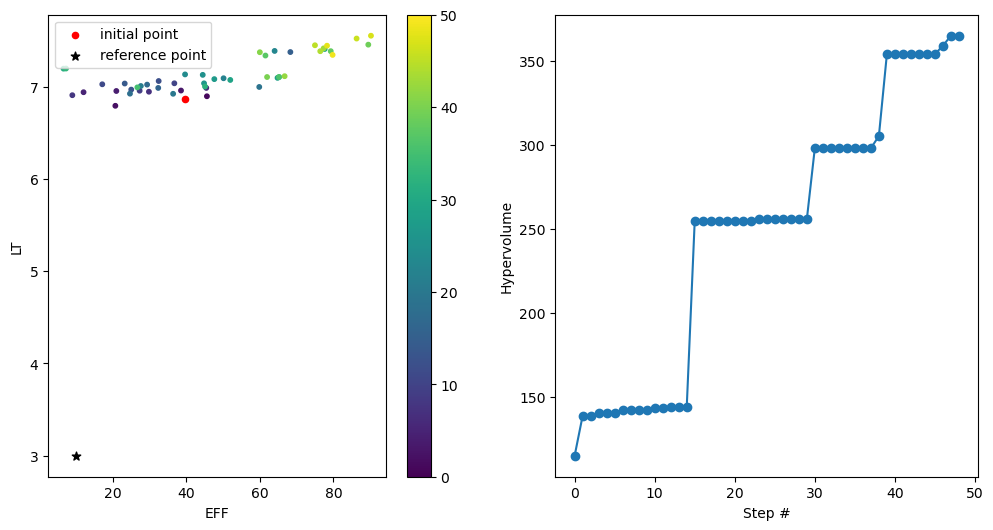

In [14]:
import matplotlib.pyplot as plt

hvs = []
for i in range(1,len(opt.data)):
    hv = opt.generator.calculate_hypervolume_at(i=i,df=opt.data)
    hvs.append(hv)

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['EFF', 'LT']
l = ax[0,0].scatter(df.loc[:,ol[0]], df.loc[:,ol[1]],10,marker='o',c=range(len(df)),vmax=len(df))
ax[0,0].scatter(df.loc[:1,ol[0]], df.loc[:1,ol[1]], 20,marker='o',c='red',label='initial point')
ax[0,0].scatter(gen.reference_point[ol[0]], gen.reference_point[ol[1]],40,marker='*',c='black',label='reference point')
ax[0,0].set_xlabel(ol[0])
ax[0,0].set_ylabel(ol[1])
fig.colorbar(l)
ax[0,0].legend()

ax[0,1].plot(hvs,marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Hypervolume')

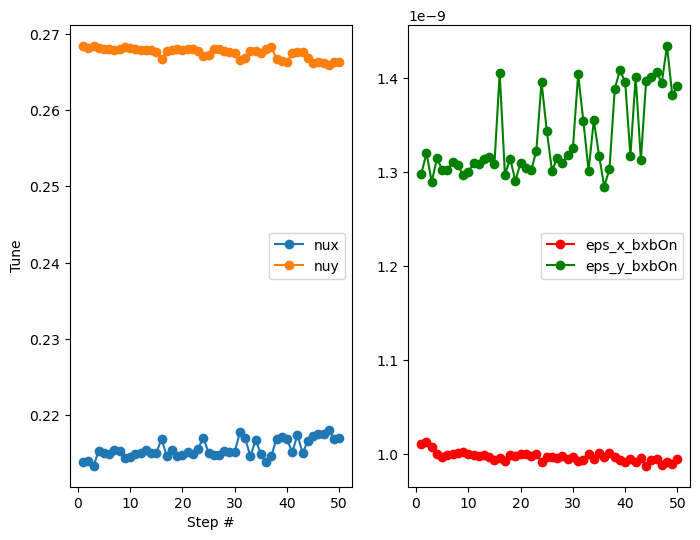

In [15]:
fig,ax = plt.subplots(1,2,squeeze=False,figsize=(8,6))
df = opt.data

ax[0,0].plot(df.loc[:,'_nux'], marker='o', label='nux')
ax[0,0].plot(df.loc[:,'_nuy'], marker='o', label='nuy')
ax[0,1].plot(df.loc[:,'_eps_x_bxbOn'], marker='o', label='eps_x_bxbOn', color='red')
ax[0,1].plot(df.loc[:,'_eps_y_bxbOn']*1e2, marker='o', label='eps_y_bxbOn', color='green')
ax[0,0].set_xlabel('Step #')
ax[0,0].set_ylabel('Tune')
ax[0,0].legend()
ax[0,1].legend()

In [16]:
# Nominal (i.e., design) sextupole settings:
opt.generate_at({k:0.0 for k in variables.keys()})
opt.evaluate_data()

[INFO ][22:34:45.635 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:34:45.638 evaluators  193] Data kwargs: row={'SH1N': 0.0, 'SH3N': 0.0, 'SH4N': 0.0, 'SL1': 0.0, 'SL2': 0.0, 'SL3': 0.0, 'SH1-DW08': 0.0, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH3-DW08': 0.0, 'SH3-DW18': 0.0, 'SH3-DW28': 0.0, 'SH4-DW08': 0.0, 'SH4-DW18': 0.0, 'SH4-DW28': 0.0}
[INFO ][22:34:45.642 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.9665824200000004, 'SH3N': -1.171021682, 'SH4N': -3.164180142, 'SL1': -2.6543212100000004, 'SL2': 7.135584290000001, 'SL3': -5.892172122000001, 'SH1-DW08': 3.9665824200000004, 'SH1-DW18': 3.9665824200000004, 'SH1-DW28': 3.9665824200000004, 'SH3-DW08': -1.171021682, 'SH3-DW18': -1.171021682, 'SH3-DW28': -1.171021682, 'SH4-DW08': -3.164180142, 'SH4-DW18': -3.164180142, 'SH4-DW28': -3.164180142}


SH1N   : +3.967 + +0.000 -> +3.967
SH3N   : -1.171 + +0.000 -> -1.171
SH4N   : -3.164 + +0.000 -> -3.164
SL1    : -2.654 + +0.000 -> -2.654
SL2    : +7.136 + +0.000 -> +7.136
SL3    : -5.892 + +0.000 -> -5.892
SH1-DW08: +3.967 + +0.000 -> +3.967
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.000 -> -1.171
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + +0.000 -> -1.171
SH4-DW08: -3.164 + +0.000 -> -3.164
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + +0.000 -> -3.164
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.050; RMS(dx, dy) [m] = (6.353e-06, 1.159e-06)
Orbit correction converged


[INFO ][22:34:50.740 opt_funcs.  734] Lifetime measurement START
[INFO ][22:34:59.684 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 7.543 (raw tau [hr] = 9.078, epsy [pm] = 14.52) (took 8.9 [s])
Inj. Eff. = 85.84 (took 18.4 [s])
Eval. func. finished.


[DEBUG][22:35:18.057 evaluators  211] Result: output={'result': {'_nux': 0.2180772635779276, '_nuy': 0.265501286751085, '_eps_x_bxbOn': 9.912032487224829e-10, '_eps_y_bxbOn': 1.4699493756971186e-11, '_eps_x_bxbOff': 9.864857416689279e-10, '_eps_y_bxbOff': 1.4521115829389483e-11, 'LT': 7.5425399444210735, '_raw_LT': 9.07783494665364, 'EFF': 85.8399052027569}, 'exception': None, 'traceback': '', 'wall_time': 32.41833133343607, 'cpu_time': 15.159247061999963}
[DEBUG][22:35:18.061 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:35:18.119 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00044.json] in [0.05324]s


MOGA add_data (+1): len(self._offspring)=3/8


In [19]:
opt.generate_at(iknobvals)
opt.evaluate_data()

[INFO ][22:36:02.153 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:36:02.156 evaluators  193] Data kwargs: row={'SH1N': -0.08, 'SH3N': -0.04, 'SH4N': 0.0, 'SL1': 0.0, 'SL2': -0.15, 'SL3': -0.15, 'SH1-DW08': 0.02, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH3-DW08': 0.02, 'SH3-DW18': 0.0, 'SH3-DW28': 0.0, 'SH4-DW08': 0.02, 'SH4-DW18': 0.0, 'SH4-DW28': 0.0}
[INFO ][22:36:02.161 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.8865824200000003, 'SH3N': -1.211021682, 'SH4N': -3.164180142, 'SL1': -2.6543212100000004, 'SL2': 6.98558429, 'SL3': -6.042172122000001, 'SH1-DW08': 3.9865824200000004, 'SH1-DW18': 3.9665824200000004, 'SH1-DW28': 3.9665824200000004, 'SH3-DW08': -1.1510216819999999, 'SH3-DW18': -1.171021682, 'SH3-DW28': -1.171021682, 'SH4-DW08': -3.144180142, 'SH4-DW18': -3.164180142, 'SH4-DW28': -3.164180142}


SH1N   : +3.967 + -0.080 -> +3.887
SH3N   : -1.171 + -0.040 -> -1.211
SH4N   : -3.164 + +0.000 -> -3.164
SL1    : -2.654 + +0.000 -> -2.654
SL2    : +7.136 + -0.150 -> +6.986
SL3    : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.020 -> +3.987
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + +0.000 -> -1.171
SH4-DW08: -3.164 + +0.020 -> -3.144
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + +0.000 -> -3.164
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.183; RMS(dx, dy) [m] = (1.234e-05, 1.200e-06)
Max FCOR I [A] = 0.183; RMS(dx, dy) [m] = (1.234e-05, 1.200e-06)
Max FCOR I [A] = 0.067; RMS(dx, dy) [m] = (6.714e-06, 1.190e-06)
Orbit correction converged


[INFO ][22:36:09.292 opt_funcs.  734] Lifetime measurement START
[INFO ][22:36:14.705 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.003 (raw tau [hr] = 7.895, epsy [pm] = 12.69) (took 5.4 [s])
Inj. Eff. = 41.43 (took 18.7 [s])
Eval. func. finished.


[DEBUG][22:36:33.448 evaluators  211] Result: output={'result': {'_nux': 0.2136217356284742, '_nuy': 0.2673933695127926, '_eps_x_bxbOn': 9.984921476654291e-10, '_eps_y_bxbOn': 1.290127905203671e-11, '_eps_x_bxbOff': 1.004535487642575e-09, '_eps_y_bxbOff': 1.268903413298722e-11, 'LT': 7.002690777568332, '_raw_LT': 7.8946854421876305, 'EFF': 41.4341990382385}, 'exception': None, 'traceback': '', 'wall_time': 31.290696893818676, 'cpu_time': 11.724924181000006}
[DEBUG][22:36:33.450 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:36:33.507 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_05_21-aps_moga-fcf44162a0-c0edb937/dump_auto_00045.json] in [0.05283]s


MOGA add_data (+1): len(self._offspring)=4/8


In [20]:
with pd.option_context('display.max_rows', 500):
    display(opt.data)

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,-0.080000,-0.040000,0.000000e+00,0.000000,-0.150000,-0.150000,0.020000,0.000000,0.000000e+00,0.020000,...,True,0.213774,0.268492,1.010412e-09,1.297638e-11,1.010052e-09,1.291231e-11,6.862815,7.481199,39.707394
2,-0.073858,-0.037524,-3.932957e-03,0.004625,-0.120728,-0.128425,0.000742,-0.016849,-1.697244e-02,0.024398,...,True,0.213896,0.268248,1.012855e-09,1.319583e-11,1.009715e-09,1.310094e-11,6.895691,7.582988,45.572217
3,-0.102387,-0.040290,1.643696e-02,-0.002753,-0.187601,-0.161271,0.030755,0.019607,1.696976e-02,0.016367,...,True,0.213317,0.268472,1.007289e-09,1.289175e-11,1.009358e-09,1.278070e-11,6.792396,7.384069,20.656015
4,-0.058829,-0.043931,8.332496e-04,0.013481,-0.135589,-0.174049,0.041344,-0.004630,-1.716346e-03,0.016908,...,True,0.215270,0.268156,9.993530e-10,1.313984e-11,1.001496e-09,1.299156e-11,6.957757,7.630857,38.520886
5,-0.087574,-0.033863,-1.687842e-02,-0.011872,-0.154344,-0.136258,0.011725,0.008001,1.714050e-03,0.022332,...,True,0.214964,0.268126,9.965241e-10,1.302154e-11,1.002288e-09,1.291120e-11,6.952793,7.606791,20.923912
6,-0.084035,-0.046828,-9.917383e-03,0.010421,-0.181295,-0.143062,0.015817,-0.007764,2.216468e-02,0.020495,...,True,0.214863,0.268004,9.987175e-10,1.301896e-11,9.980167e-10,1.294115e-11,6.939527,7.607550,12.003188
7,-0.065715,-0.035378,8.088432e-03,-0.012062,-0.109035,-0.185298,0.033426,0.004869,-2.216819e-02,0.018509,...,True,0.215361,0.267943,9.994948e-10,1.310606e-11,9.965056e-10,1.313851e-11,6.986219,7.719816,45.395969
8,-0.092905,-0.038744,1.390933e-02,0.003324,-0.161047,-0.150019,0.020586,-0.020031,6.930579e-03,0.014659,...,True,0.215290,0.268126,1.001098e-09,1.306742e-11,9.997411e-10,1.300125e-11,6.944894,7.639931,29.795216
9,-0.102808,-0.046641,-9.917383e-03,-0.002662,-0.181295,-0.142321,0.029954,0.016101,2.214582e-02,0.016554,...,True,0.214385,0.268339,1.001984e-09,1.296823e-11,9.991236e-10,1.288131e-11,6.907144,7.577430,8.951967
10,-0.096124,-0.040478,1.643696e-02,0.010331,-0.187601,-0.162012,0.016619,0.019607,1.698862e-02,0.008663,...,True,0.214415,0.268248,9.995523e-10,1.299194e-11,9.985900e-10,1.281522e-11,6.955892,7.624178,27.265912


In [21]:
# This will save optimizer state
if not TEST_MODE:
    opt.state_to_json(f'{datetime.now():%Y%m%dT%H%M%S}_{NAME_ROOT}_dump.json')